In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot

import numpy as np
np.seterr(divide='ignore', invalid='ignore', over='ignore')
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function
from FireHydrant.Tools.uproothelpers import fromNestNestIndexArray

# import pandas as pd
import awkward
from uproot_methods import TLorentzVectorArray
from FireHydrant.Tools.trigger import Triggers

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import json
import os
from os.path import join
datasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_nonempty_v2.json')))
scales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_v2.json')))

# flatten datasets
datasets = {}
for group in datasets_:
    for tag in datasets_[group]:
        datasets[tag] = datasets_[group][tag]

# flatten scales
scales = {}
for group in scales_:
    for tag in scales_[group]:
        scales[tag] = scales_[group][tag]

lumi = 59.74*1e3
for k in scales:
    scales[k] *= lumi

# mapping
mapping = {}
for k in datasets_: mapping[k] = list(datasets_[k])
    
    
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}

In [3]:
ptbinning = np.concatenate([np.arange(0, 400, 10),
                           np.arange(400, 600, 20),
                           np.arange(600, 800, 50)])
massbinning = np.concatenate([np.arange(0, 5, 0.5),
                             np.arange(5, 20, 1)])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "leptonjet": hist.Hist("#counts", dataset_axis, pt_axis, mass_axis, eta_axis, phi_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis),
            'run': processor.column_accumulator(np.zeros(shape=(0,))),
            'lumi': processor.column_accumulator(np.zeros(shape=(0,))),
            'event': processor.column_accumulator(np.zeros(shape=(0,))),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']
        run = df['run']
        lumi = df['lumi']
        event = df['event']
        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        
#         nvtx = df['npv']
#         pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#         wgts.add('pileup', pu, puUp, puDown)
        
#         metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         wgts.add('metfilters', metfiltermask)

#         wnlo = np.ones_like(df.size)
#         if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#             genparticles = JaggedCandidateArray.candidatesfromcounts(
#                 df['gen_p4'],
#                 px=df['gen_p4.fCoordinates.fX'],
#                 py=df['gen_p4.fCoordinates.fY'],
#                 pz=df['gen_p4.fCoordinates.fZ'],
#                 energy=df['gen_p4.fCoordinates.fT'],
#                 pid=df['gen_pid'],
#             )
#             gentops = genparticles[np.abs(genparticles.pid)==6]
#             genws = genparticles[np.abs(genparticles.pid)==24]
#             genzs = genparticles[np.abs(genparticles.pid)==23]

#             if 'TTJets' in dataset:
#                 wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#             elif 'WJets' in dataset:
#                 wnlo = self.nlo_w(genws[0].p4.pt.sum())
#             elif 'DYJets' in dataset:
#                 wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#         wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        if dileptonjets.size==0: return output
        wgt = weight[twoleptonjets]
        
        run = run[twoleptonjets]
        lumi = lumi[twoleptonjets]
        event = event[twoleptonjets]
        
        output['run'] += processor.column_accumulator(run)
        output['lumi'] += processor.column_accumulator(lumi)
        output['event'] += processor.column_accumulator(event)

        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]

#         leadingLjPair = leptonjetpair[sumpt.argmax()]
#         controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
#         leptonjets_ = dileptonjets[controlregion.flatten()]
#         wgt = wgt[controlregion.flatten()]
        leptonjets_ = dileptonjets

        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        output['leptonjet'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(),
                                 eta=leptonjets_.eta.flatten(),
                                 phi=leptonjets_.phi.flatten(),
                                 mass=leptonjets_.mass.flatten(),
                                 weight=(leptonjets_.pt.ones_like()*wgt).flatten())
        output['ljpair'].fill(dataset=dataset, dphi=(lj0.p4.delta_phi(lj1.p4)).flatten(),
                             weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            if not isinstance(accumulator[k], hist.Hist): continue
            accumulator[k].scale(scales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [4]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2465/2465 [03:03<00:00, 13.45items/s]


In [4]:
outputs={}
for k in datasets:
    outputs[k] = processor.run_uproot_job({k: datasets[k]},
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 69/69 [00:18<00:00,  3.82items/s]


In [5]:
for k, output in outputs.items():
    runs, lumis, events = output['run'].value.astype(int), output['lumi'].value.astype(int), output['event'].value.astype(int)
    print(f'\n{k}')
    if runs.size==0: continue
    for r,l,e in np.nditer([runs, lumis, events]):
        print('{}:{}:{}'.format(r, l, e))


QCD_Pt-15to20

QCD_Pt-20to30

QCD_Pt-30to50

QCD_Pt-50to80
1:9168:262987059
1:4467:128130274

QCD_Pt-80to120
1:2519:61469199
1:5764:140637777
1:2749:67086890
1:9862:240631817
1:25464:621274968
1:25863:631012355
1:17537:427867275

QCD_Pt-120to170
1:8190:209438390
1:191:4865179
1:6895:176330004
1:7203:184204313
1:7207:184301191
1:3506:89664395
1:14873:380355483
1:14778:377927487
1:14956:382493885
1:4426:113178294
1:12782:326881175
1:4607:117811210

QCD_Pt-170to300
1:8:167421
1:17181:408042652
1:8963:212868264
1:14346:340696289
1:16796:398902850
1:5560:132028118
1:16777:398434616
1:20636:490082800
1:11351:269572841
1:16350:388307709
1:13951:331318599
1:19580:465018933
1:22080:524385010
1:3288:78073049
1:14544:345401115
1:13927:330757066
1:17934:425930052
1:8694:206478418
1:8801:209018495
1:18855:447791806
1:17563:417120257
1:9481:225155007
1:21697:515287201
1:395:9366803
1:7730:183572284
1:22830:542203853
1:11665:277041059

QCD_Pt-300to470
1:34122:257478541
1:14988:113096548
1:38328:2892

In [ ]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['leptonjet_cat'].sum('eta', 'phi', 'mass', overflow='over'), overlay='cat', ax=ax, stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_yscale('symlog')
ax.set_title('[all region] leptonJets pT', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

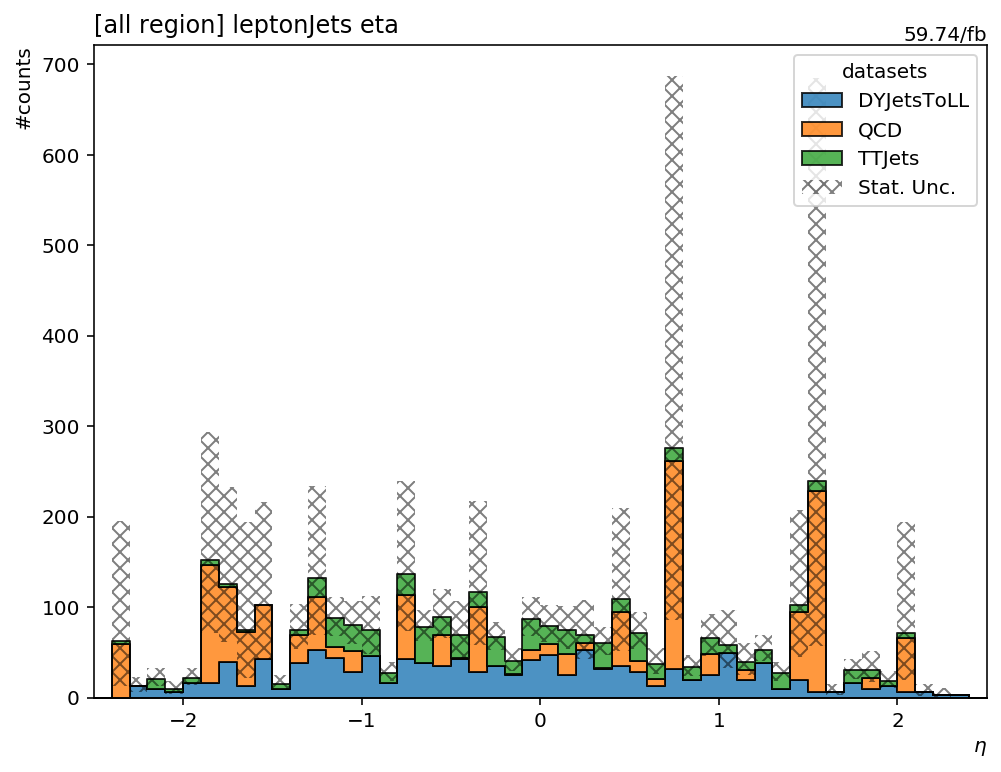

In [6]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['leptonjet_cat'].sum('pt', 'phi', 'mass', overflow='over'), overlay='cat', ax=ax, stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[all region] leptonJets eta', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

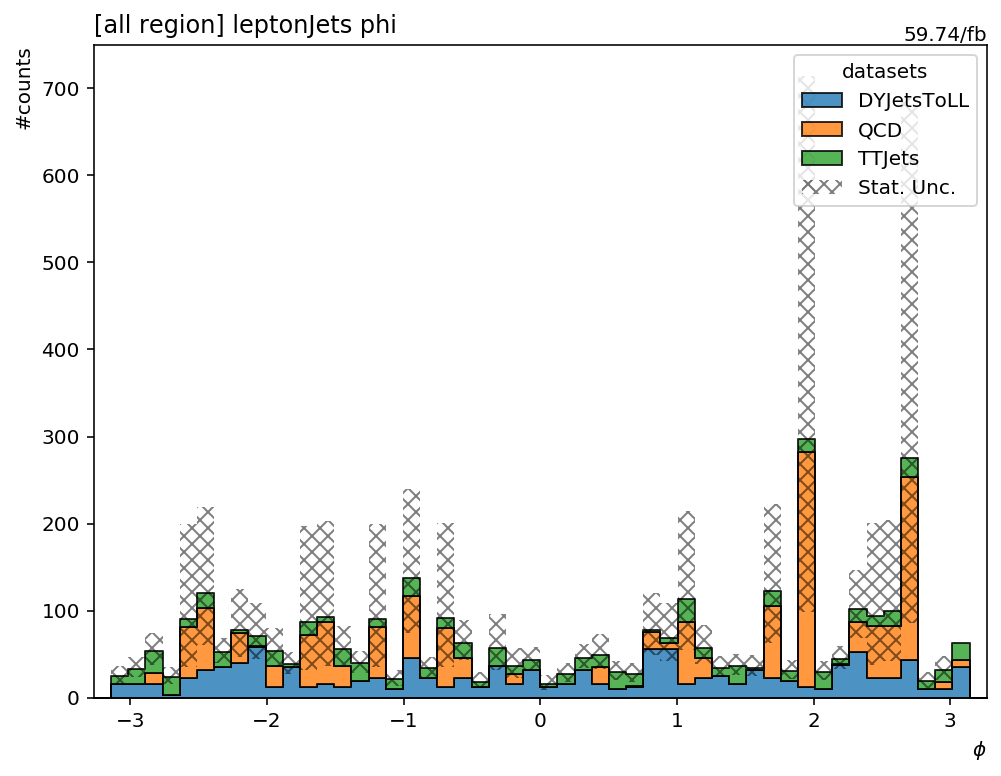

In [7]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['leptonjet_cat'].sum('pt', 'eta', 'mass', overflow='over'), overlay='cat', ax=ax, stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[all region] leptonJets phi', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

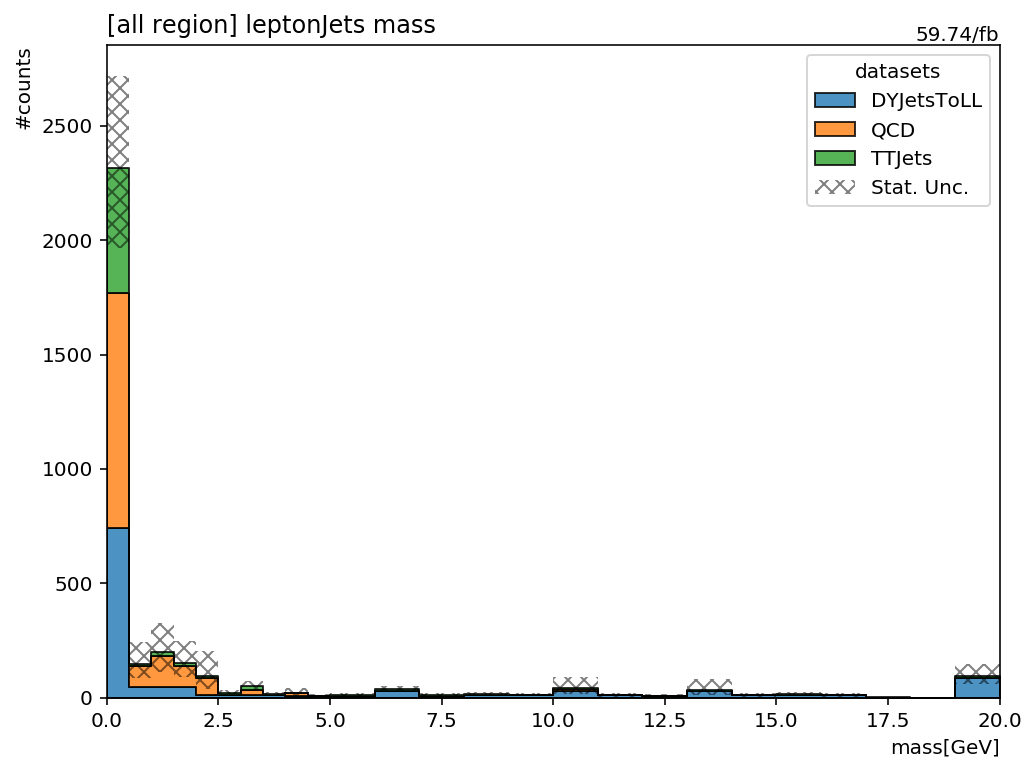

In [8]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['leptonjet_cat'].sum('pt', 'eta', 'phi', overflow='over'), overlay='cat', ax=ax, stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[all region] leptonJets mass', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

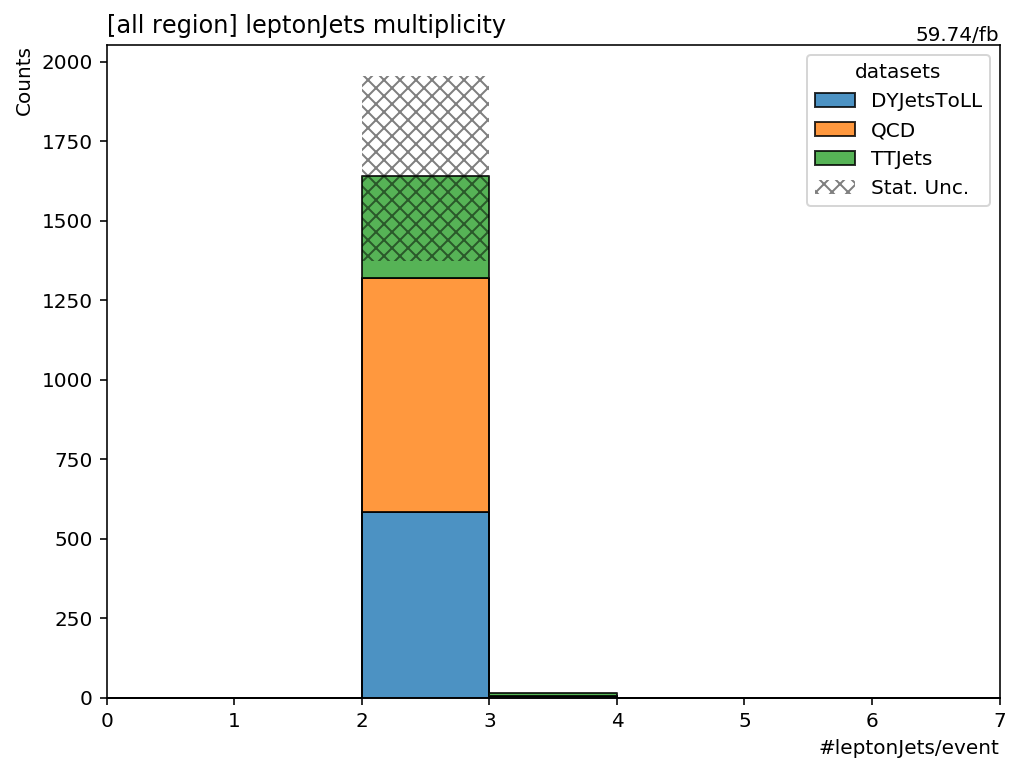

In [9]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['multi_cat'], overlay='cat', stack=True, ax=ax, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[all region] leptonJets multiplicity', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

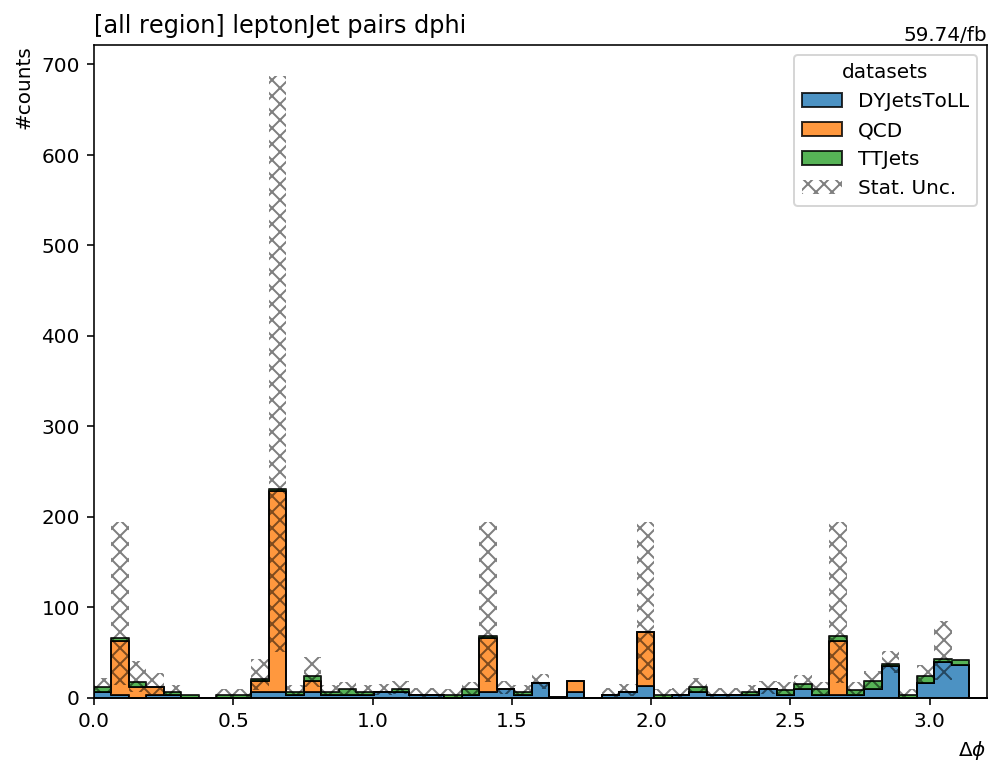

In [10]:
fig, ax =plt.subplots(1,1,figsize=(8,6))
hist.plot1d(output['ljpair_cat'], overlay='cat', stack=True, ax=ax, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
ax.set_title('[all region] leptonJet pairs dphi', x=0.0, ha="left")
ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## split by types

In [13]:
ptbinning = np.concatenate([np.arange(0, 400, 10),
                           np.arange(400, 600, 20),
                           np.arange(600, 800, 50)])
massbinning = np.concatenate([np.arange(0, 5, 0.5),
                             np.arange(5, 20, 1)])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
#         nvtx = df['npv']
#         pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#         wgts.add('pileup', pu, puUp, puDown)
        
        triggermask = np.logical_and.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        
#         metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         wgts.add('metfilters', metfiltermask)

#         wnlo = np.ones_like(df.size)
#         if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#             genparticles = JaggedCandidateArray.candidatesfromcounts(
#                 df['gen_p4'],
#                 px=df['gen_p4.fCoordinates.fX'],
#                 py=df['gen_p4.fCoordinates.fY'],
#                 pz=df['gen_p4.fCoordinates.fZ'],
#                 energy=df['gen_p4.fCoordinates.fT'],
#                 pid=df['gen_pid'],
#             )
#             gentops = genparticles[np.abs(genparticles.pid)==6]
#             genws = genparticles[np.abs(genparticles.pid)==24]
#             genzs = genparticles[np.abs(genparticles.pid)==23]

#             if 'TTJets' in dataset:
#                 wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#             elif 'WJets' in dataset:
#                 wnlo = self.nlo_w(genws[0].p4.pt.sum())
#             elif 'DYJets' in dataset:
#                 wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#         wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
#         leptonjetpair = dileptonjets.distincts()
#         sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
#         if sumpt.size==0: return output
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]

#         leadingLjPair = leptonjetpair[sumpt.argmax()]
#         controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
#         leptonjets_ = dileptonjets[controlregion.flatten()]
#         wgt = wgt[controlregion.flatten()]
        leptonjets_ = dileptonjets

        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)
        output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)
        output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)
        output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt)

        output['ljpair'].fill(dataset=dataset, dphi=(lj0.p4.delta_phi(lj1.p4)).flatten(),
                             weight=wgt)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [14]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2435/2435 [01:33<00:00, 25.97items/s]


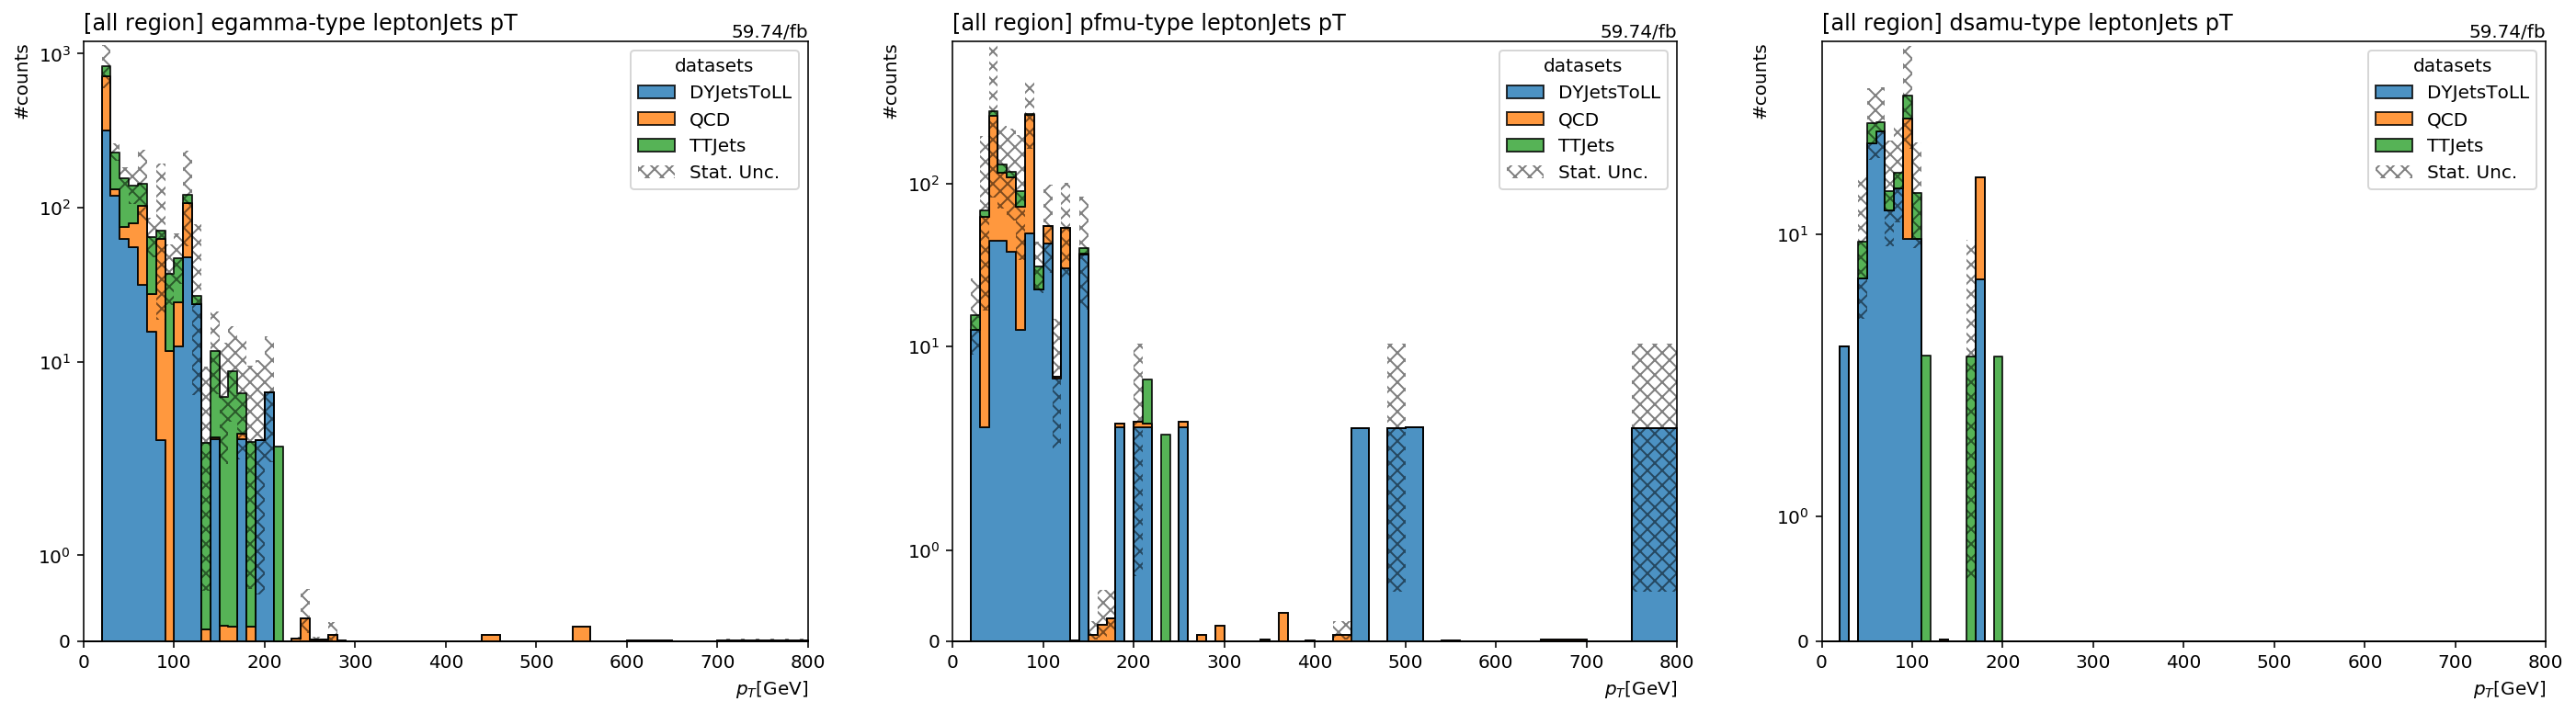

In [15]:
fig, axes =plt.subplots(1,3,figsize=(24,6))
hist.plot1d(output['ljpt_cat'].integrate('label', slice(1,2))
            , overlay='cat', ax=axes[0], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region] egamma-type leptonJets pT', x=0.0, ha="left")
hist.plot1d(output['ljpt_cat'].integrate('label', slice(2,3))
            , overlay='cat', ax=axes[1], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region] pfmu-type leptonJets pT', x=0.0, ha="left")
hist.plot1d(output['ljpt_cat'].integrate('label', slice(3,4))
            , overlay='cat', ax=axes[2], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[2].set_title('[all region] dsamu-type leptonJets pT', x=0.0, ha="left")

for ax in axes:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

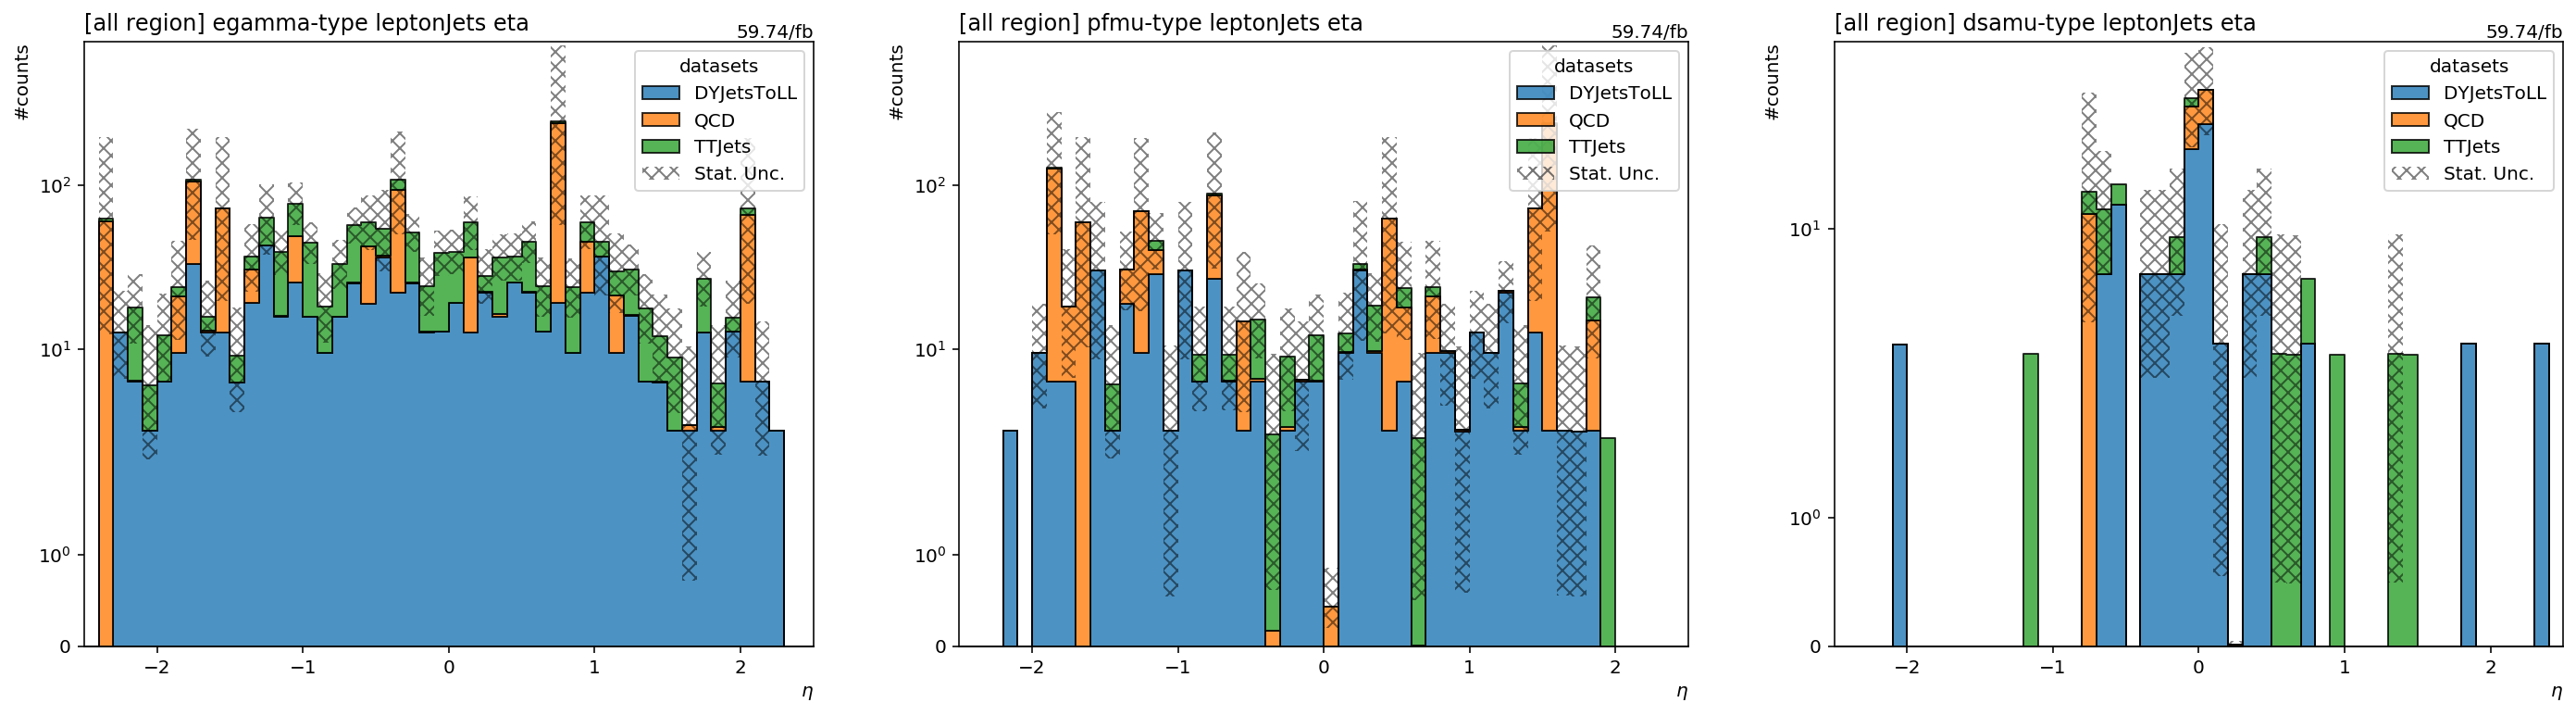

In [16]:
fig, axes =plt.subplots(1,3,figsize=(24,6))
hist.plot1d(output['ljeta_cat'].integrate('label', slice(1,2))
            , overlay='cat', ax=axes[0], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region] egamma-type leptonJets eta', x=0.0, ha="left")
hist.plot1d(output['ljeta_cat'].integrate('label', slice(2,3))
            , overlay='cat', ax=axes[1], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region] pfmu-type leptonJets eta', x=0.0, ha="left")
hist.plot1d(output['ljeta_cat'].integrate('label', slice(3,4))
            , overlay='cat', ax=axes[2], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[2].set_title('[all region] dsamu-type leptonJets eta', x=0.0, ha="left")

for ax in axes:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

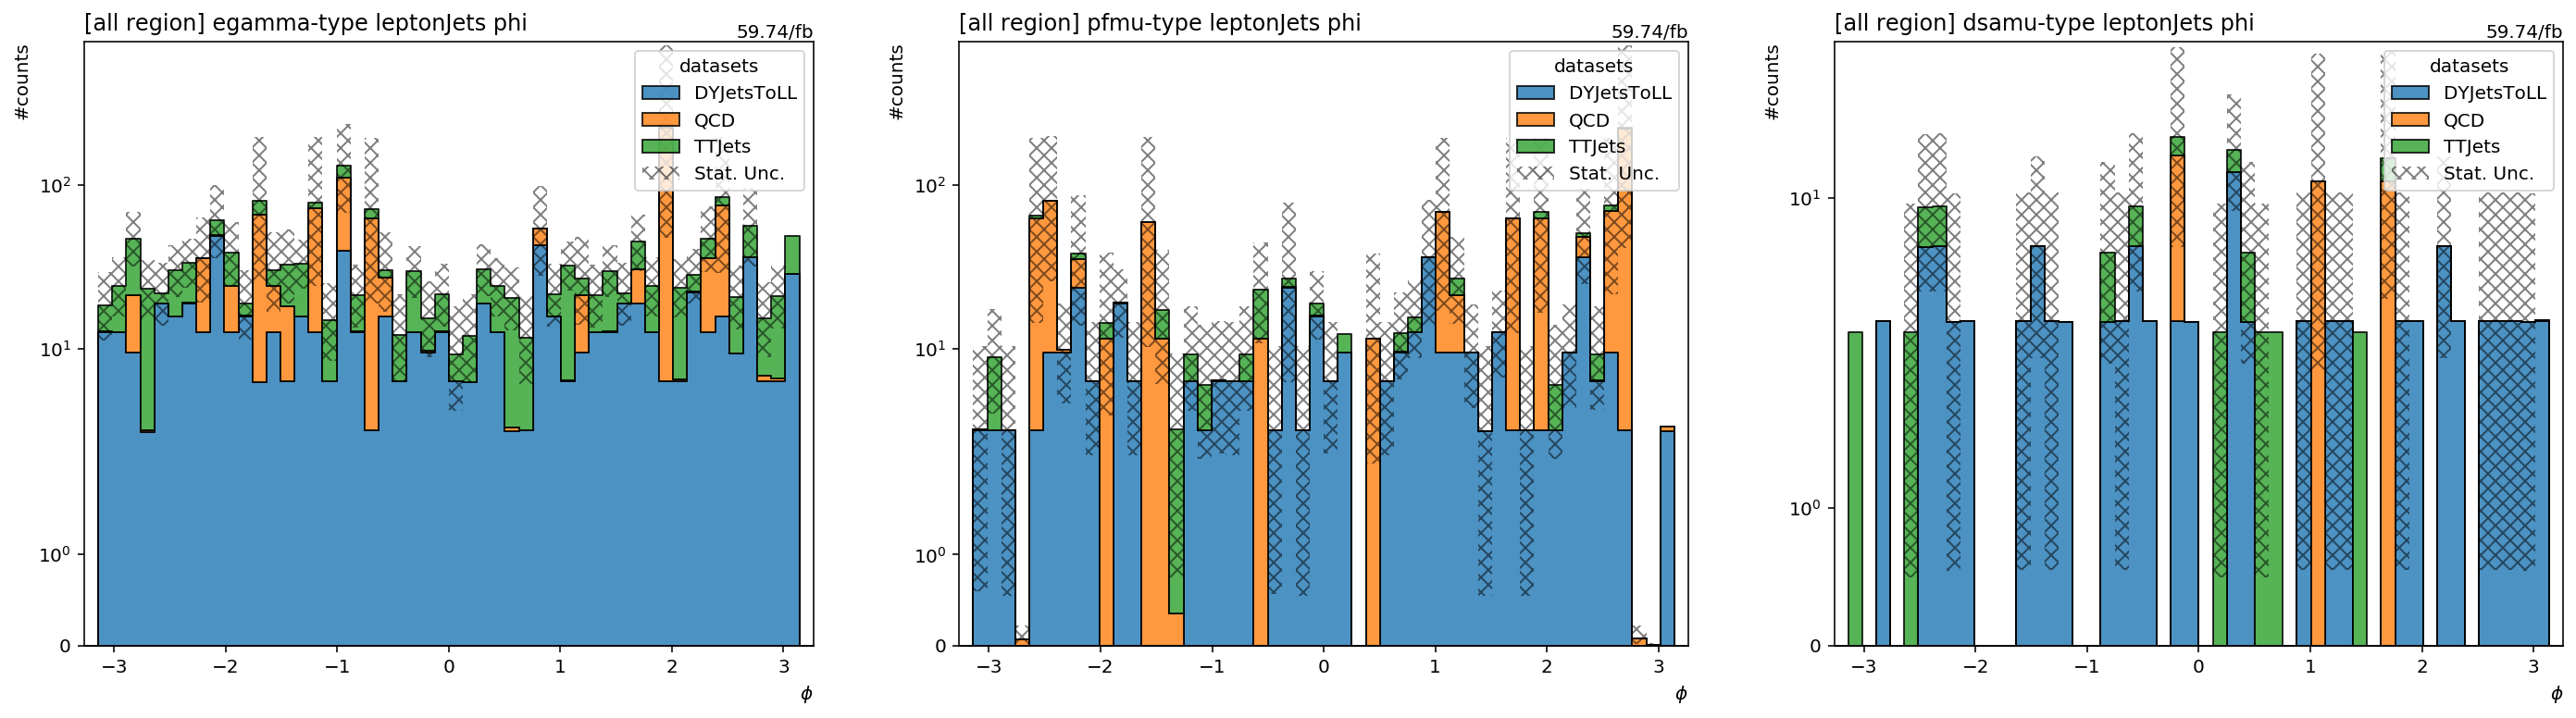

In [17]:
fig, axes =plt.subplots(1,3,figsize=(24,6))
hist.plot1d(output['ljphi_cat'].integrate('label', slice(1,2))
            , overlay='cat', ax=axes[0], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region] egamma-type leptonJets phi', x=0.0, ha="left")
hist.plot1d(output['ljphi_cat'].integrate('label', slice(2,3))
            , overlay='cat', ax=axes[1], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region] pfmu-type leptonJets phi', x=0.0, ha="left")
hist.plot1d(output['ljphi_cat'].integrate('label', slice(3,4))
            , overlay='cat', ax=axes[2], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[2].set_title('[all region] dsamu-type leptonJets phi', x=0.0, ha="left")

for ax in axes:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

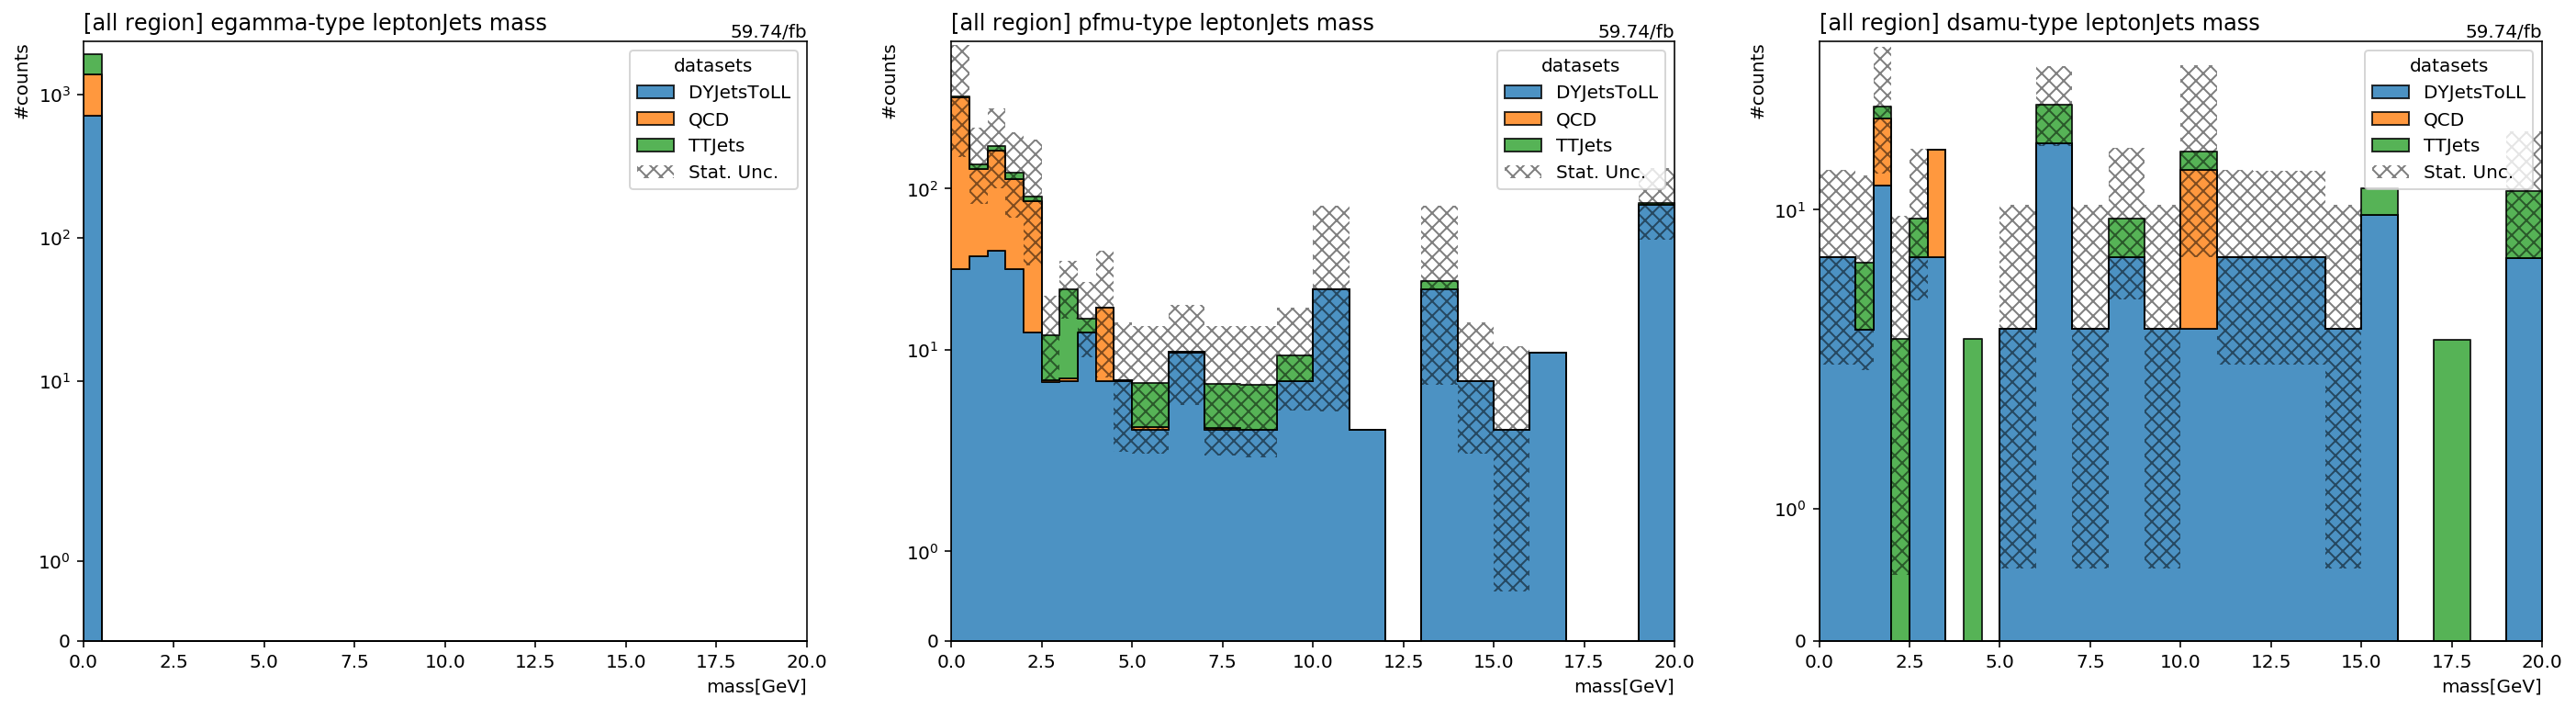

In [18]:
fig, axes =plt.subplots(1,3,figsize=(24,6))
hist.plot1d(output['ljmass_cat'].integrate('label', slice(1,2))
            , overlay='cat', ax=axes[0], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region] egamma-type leptonJets mass', x=0.0, ha="left")
hist.plot1d(output['ljmass_cat'].integrate('label', slice(2,3))
            , overlay='cat', ax=axes[1], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region] pfmu-type leptonJets mass', x=0.0, ha="left")
hist.plot1d(output['ljmass_cat'].integrate('label', slice(3,4))
            , overlay='cat', ax=axes[2], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[2].set_title('[all region] dsamu-type leptonJets mass', x=0.0, ha="left")

for ax in axes:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

## split by channels

In [16]:
ptbinning = np.concatenate([np.arange(0, 300, 10),])
massbinning = np.concatenate([np.arange(0, 20, 1),])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 24, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 20, -np.pi, np.pi)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 20, 0, np.pi)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            "ljpair": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            '4mu__run': processor.column_accumulator(np.zeros(shape=(0,))),
            '4mu__lumi': processor.column_accumulator(np.zeros(shape=(0,))),
            '4mu__event': processor.column_accumulator(np.zeros(shape=(0,))),
            '2mu2e__run': processor.column_accumulator(np.zeros(shape=(0,))),
            '2mu2e__lumi': processor.column_accumulator(np.zeros(shape=(0,))),
            '2mu2e__event': processor.column_accumulator(np.zeros(shape=(0,))),
        })
#         self.pucorrs = get_pu_weights_function()
#         self.nlo_w = get_nlo_weight_function('w')
#         self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']
        run=df['run']
        lumi=df['lumi']
        event=df['event']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
#         nvtx = df['npv']
#         pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#         wgts.add('pileup', pu, puUp, puDown)
        triggermask = np.logical_and.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
#         metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         wgts.add('metfilters', metfiltermask)

#         wnlo = np.ones_like(df.size)
#         if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#             genparticles = JaggedCandidateArray.candidatesfromcounts(
#                 df['gen_p4'],
#                 px=df['gen_p4.fCoordinates.fX'],
#                 py=df['gen_p4.fCoordinates.fY'],
#                 pz=df['gen_p4.fCoordinates.fZ'],
#                 energy=df['gen_p4.fCoordinates.fT'],
#                 pid=df['gen_pid'],
#             )
#             gentops = genparticles[np.abs(genparticles.pid)==6]
#             genws = genparticles[np.abs(genparticles.pid)==24]
#             genzs = genparticles[np.abs(genparticles.pid)==23]

#             if 'TTJets' in dataset:
#                 wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#             elif 'WJets' in dataset:
#                 wnlo = self.nlo_w(genws[0].p4.pt.sum())
#             elif 'DYJets' in dataset:
#                 wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#         wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
#         leptonjetpair = dileptonjets.distincts()
#         sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
#         if sumpt.size==0: return output
        if dileptonjets.size==0: return output
        run=run[twoleptonjets]
        lumi=lumi[twoleptonjets]
        event=event[twoleptonjets]
        
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        output['4mu__run'] += processor.column_accumulator(run[channel_==2])
        output['4mu__lumi'] += processor.column_accumulator(lumi[channel_==2])
        output['4mu__event'] += processor.column_accumulator(event[channel_==2])
        output['2mu2e__run'] += processor.column_accumulator(run[channel_==1])
        output['2mu2e__lumi'] += processor.column_accumulator(lumi[channel_==1])
        output['2mu2e__event'] += processor.column_accumulator(event[channel_==1])

#         leadingLjPair = leptonjetpair[sumpt.argmax()]
#         controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
#         leptonjets_ = dileptonjets[controlregion.flatten()]
#         wgt = wgt[controlregion.flatten()]
        leptonjets_ = dileptonjets

        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)

        output['ljpair'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            if not isinstance(accumulator[k], hist.Hist): continue
            accumulator[k].scale(scales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [17]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2440/2440 [01:31<00:00, 26.81items/s]


In [9]:
def makeplot(key, text, overflow='over', logy=True):
    fig, axes =plt.subplots(2,3,figsize=(24,12))
    hist.plot1d(output[key].integrate('label', slice(1,2)).integrate('channel', slice(1,2))
                , overlay='cat', ax=axes[0][0], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[0][0].set_title(f'[all region|2mu2e] egamma-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(2,3)).integrate('channel', slice(1,2))
                , overlay='cat', ax=axes[0][1], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[0][1].set_title(f'[all region|2mu2e] pfmu-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(3,4)).integrate('channel', slice(1,2))
                , overlay='cat', ax=axes[0][2], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[0][2].set_title(f'[all region|2mu2e] dsamu-type leptonJets {text}', x=0.0, ha="left")

    hist.plot1d(output[key].integrate('label', slice(1,2)).integrate('channel', slice(2,3))
                , overlay='cat', ax=axes[1][0], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[1][0].set_title(f'[all region|4mu] egamma-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(2,3)).integrate('channel', slice(2,3))
                , overlay='cat', ax=axes[1][1], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[1][1].set_title(f'[all region|4mu] pfmu-type leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].integrate('label', slice(3,4)).integrate('channel', slice(2,3))
                , overlay='cat', ax=axes[1][2], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[1][2].set_title(f'[all region|4mu] dsamu-type leptonJets {text}', x=0.0, ha="left")

    for ax in axes.flat:
        ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


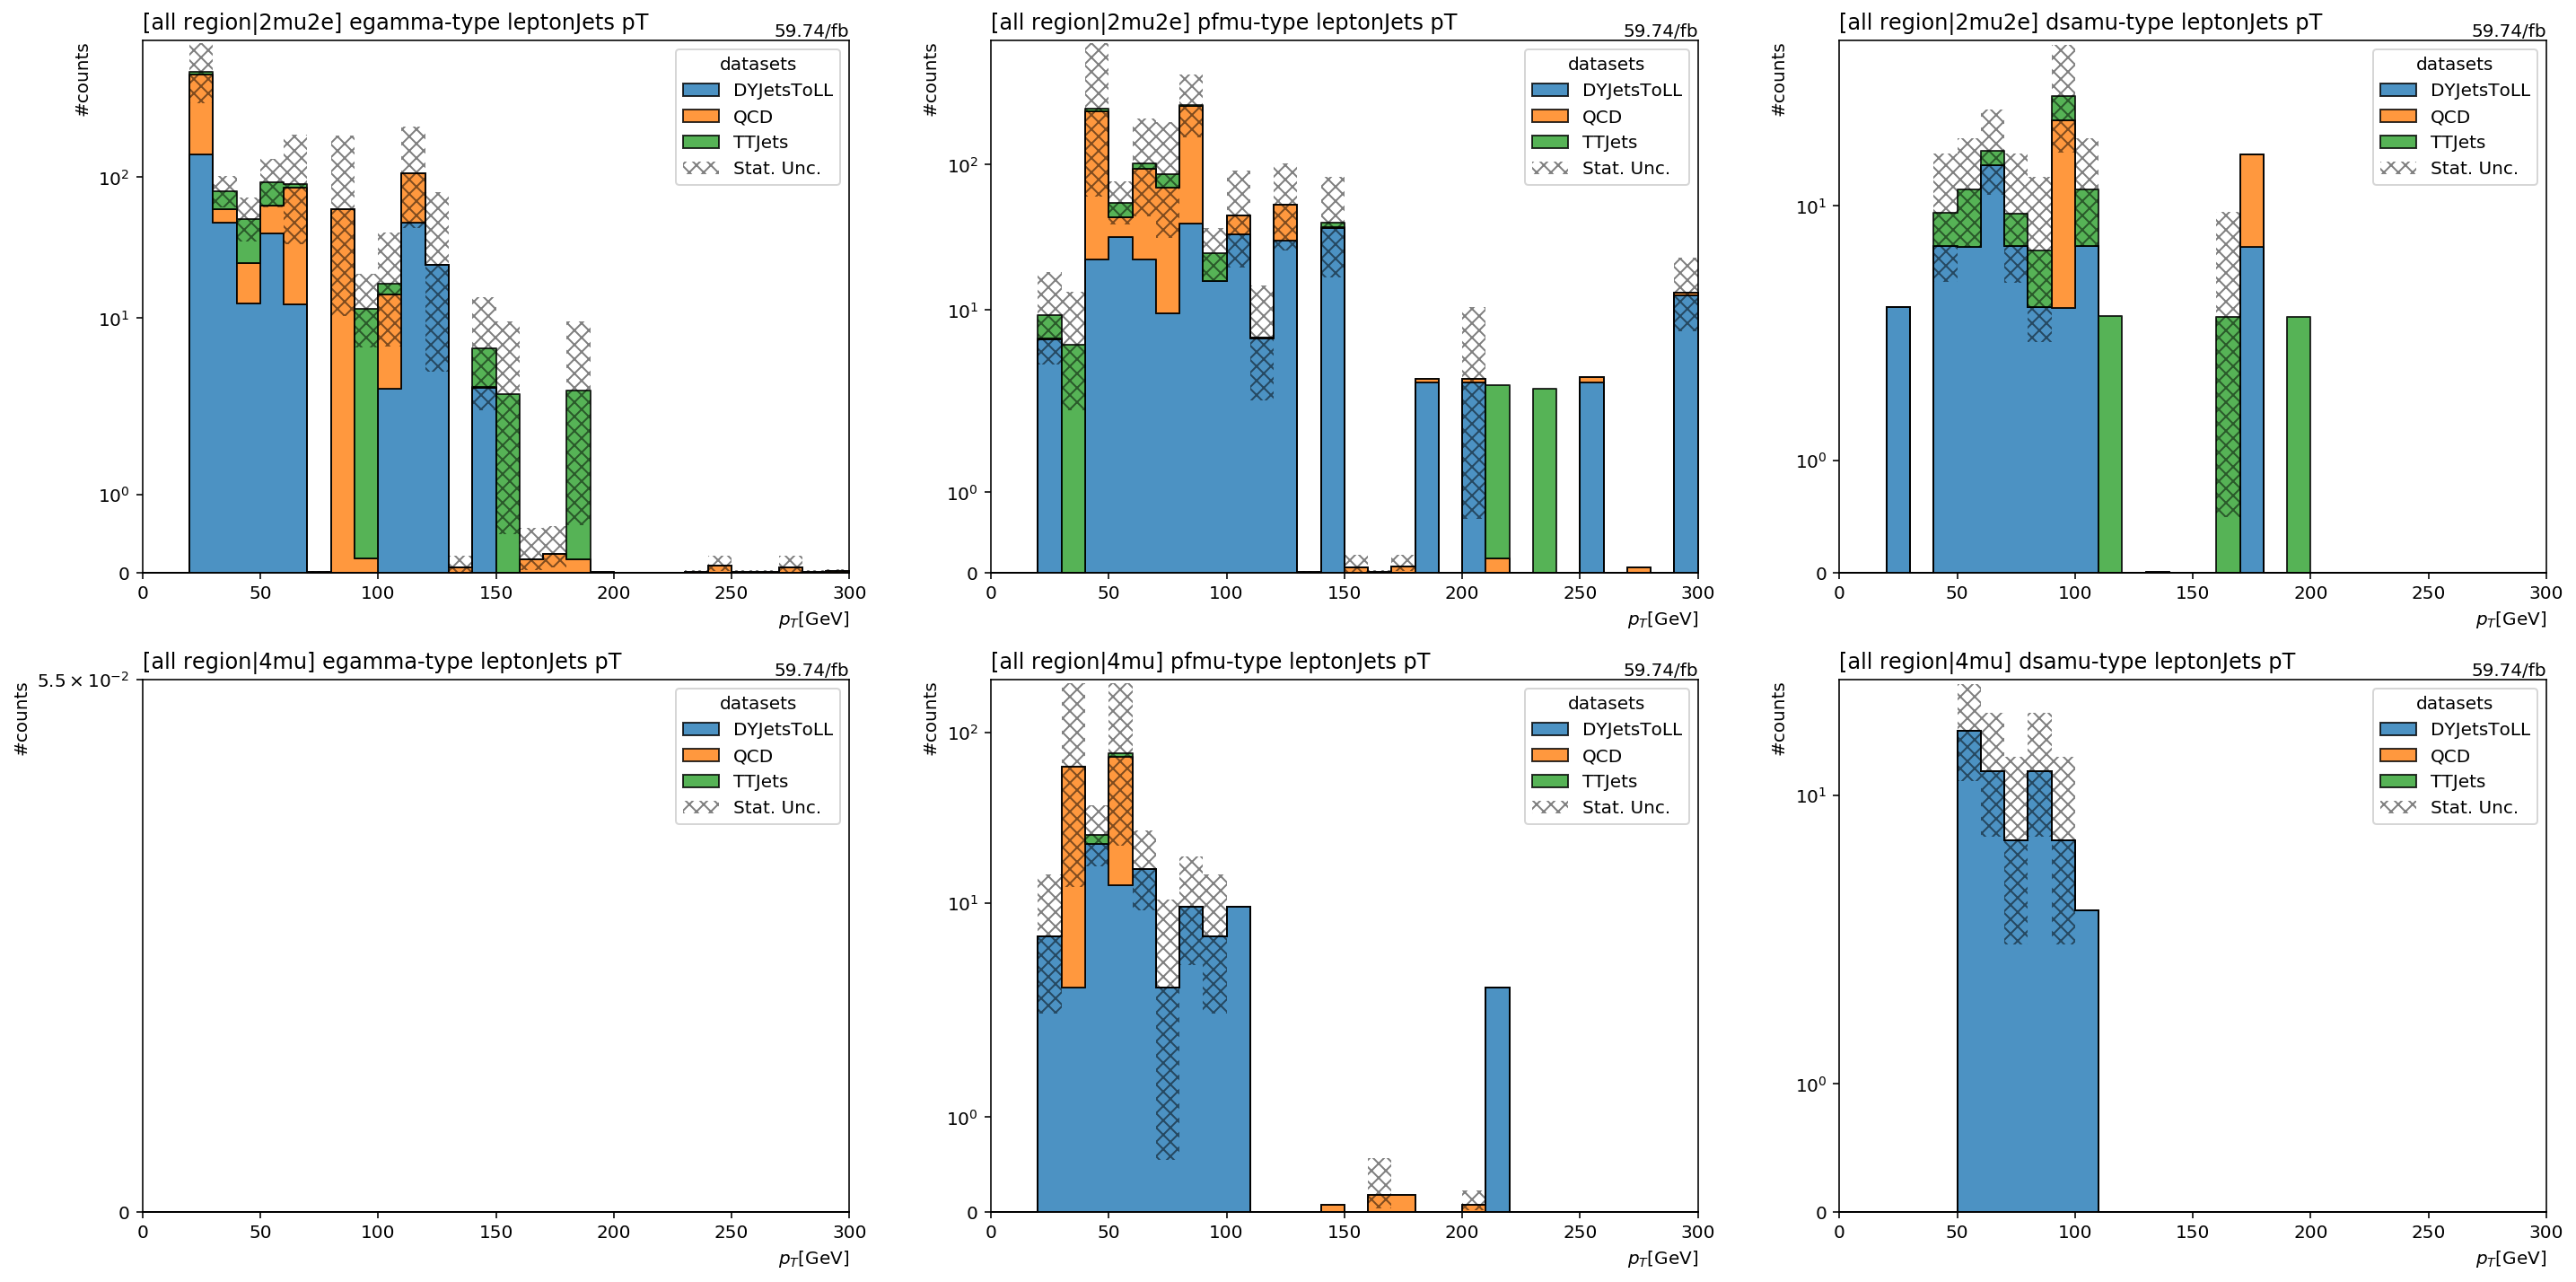

In [11]:
makeplot('ljpt_cat', 'pT')

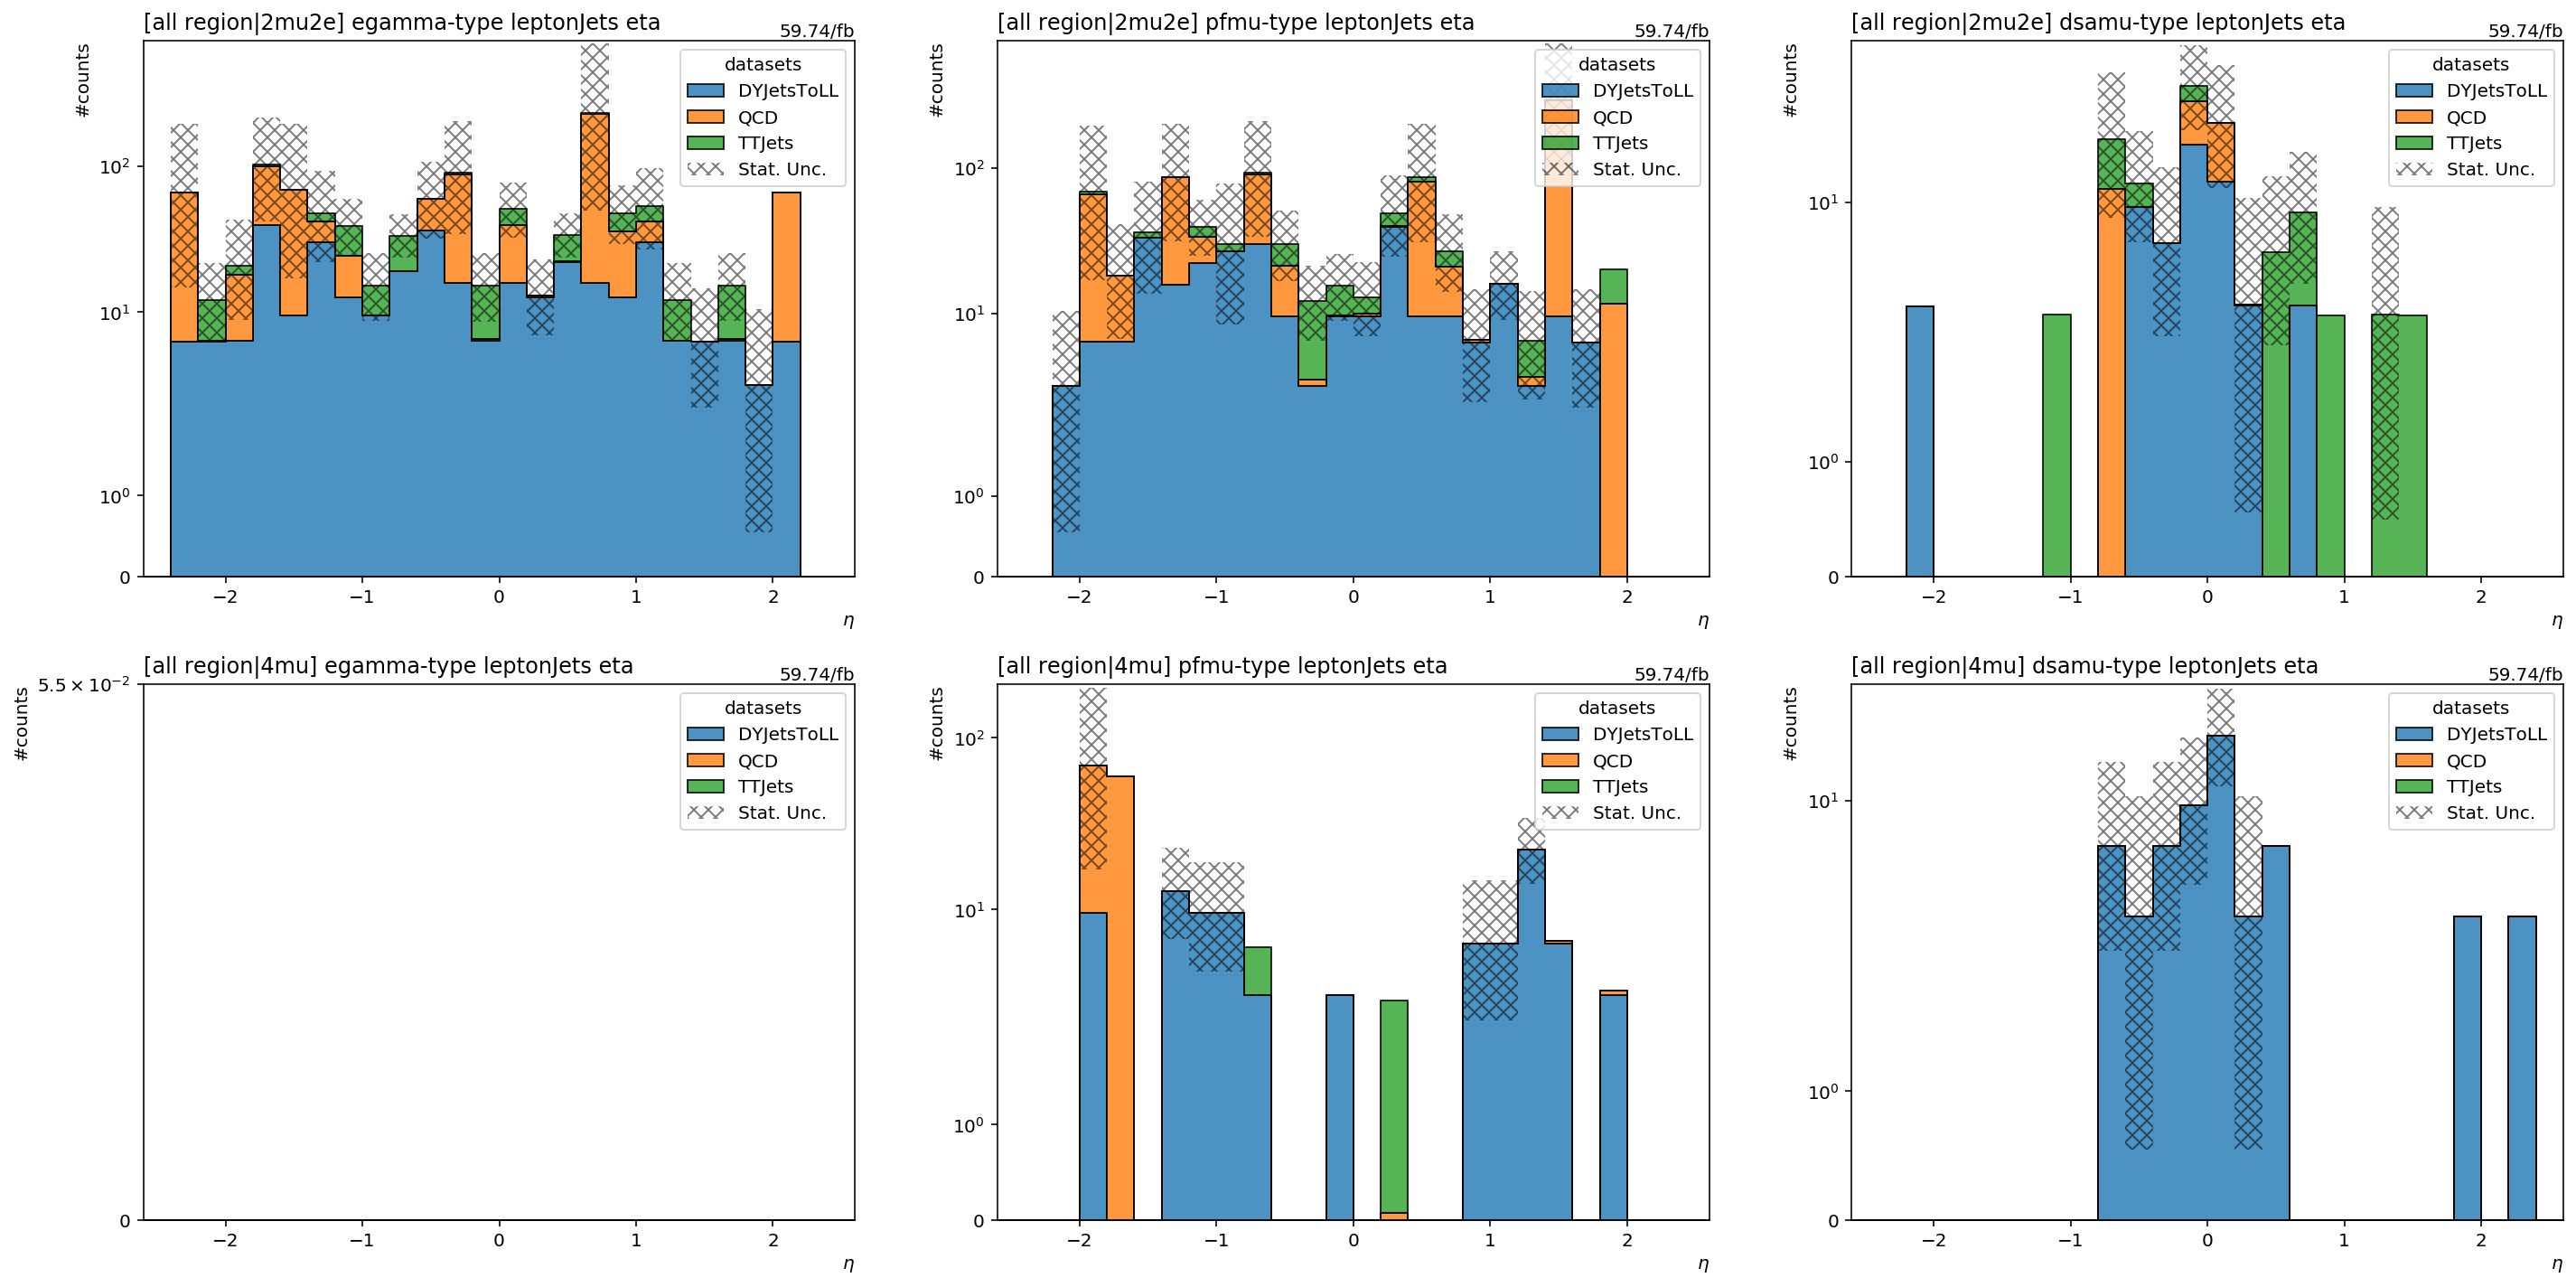

In [12]:
makeplot('ljeta_cat', 'eta', overflow='all')

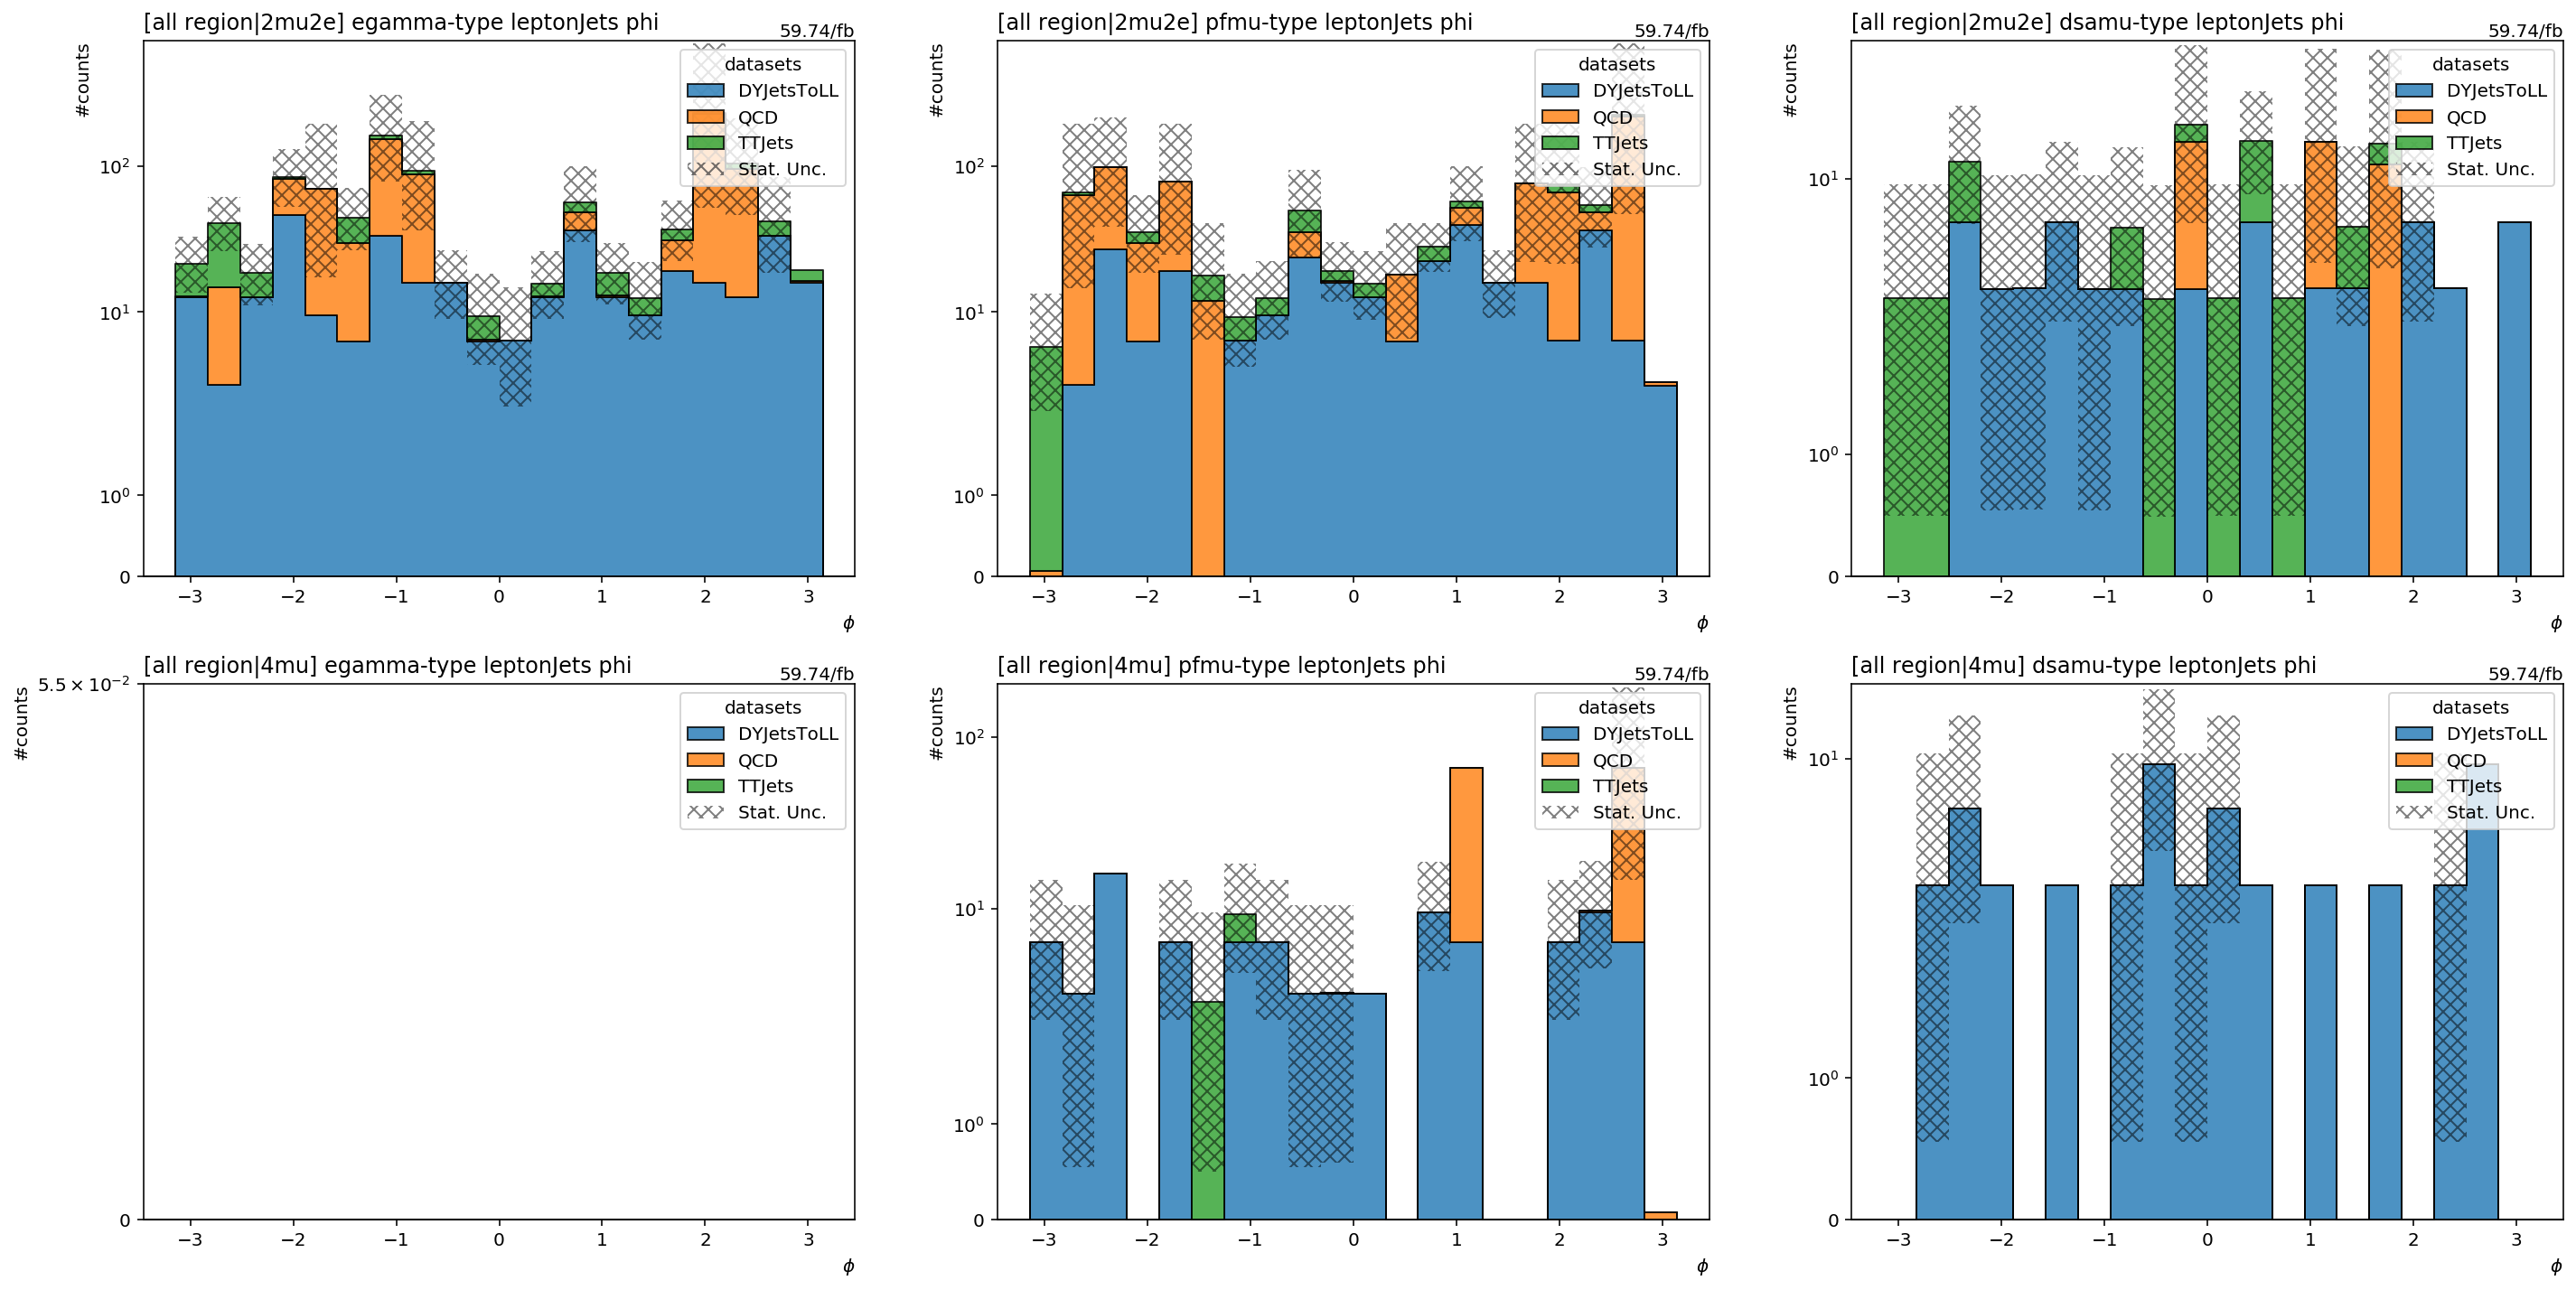

In [13]:
makeplot('ljphi_cat', 'phi', overflow='all')

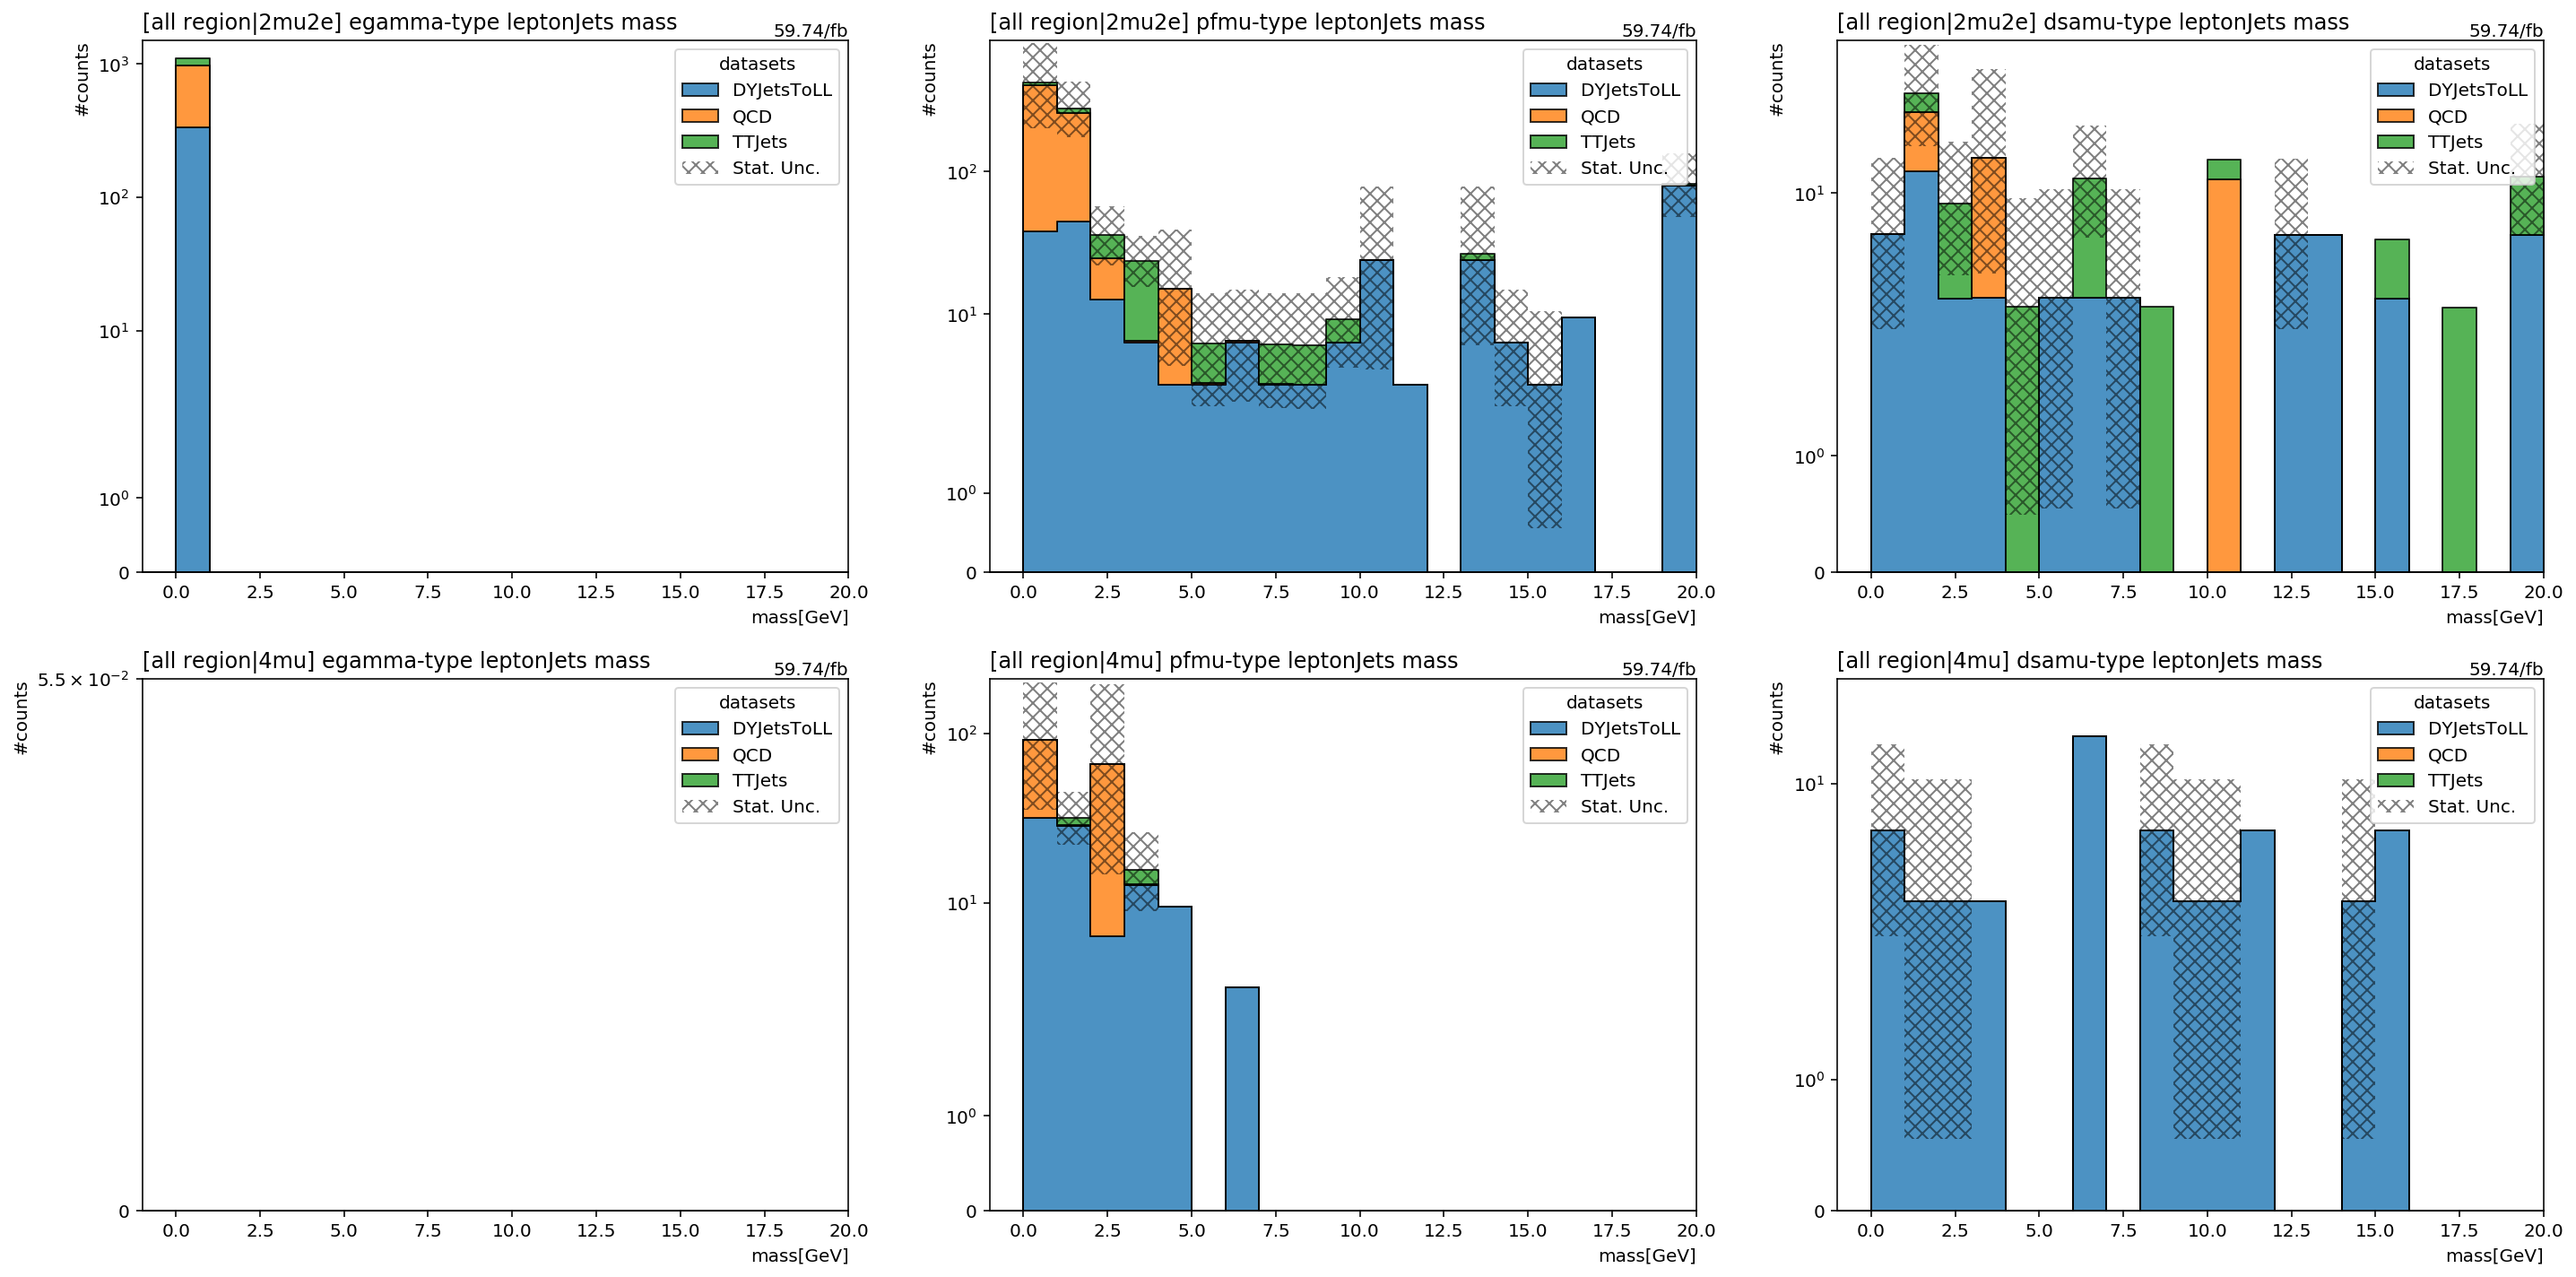

In [14]:
makeplot('ljmass_cat', 'mass', overflow='all')

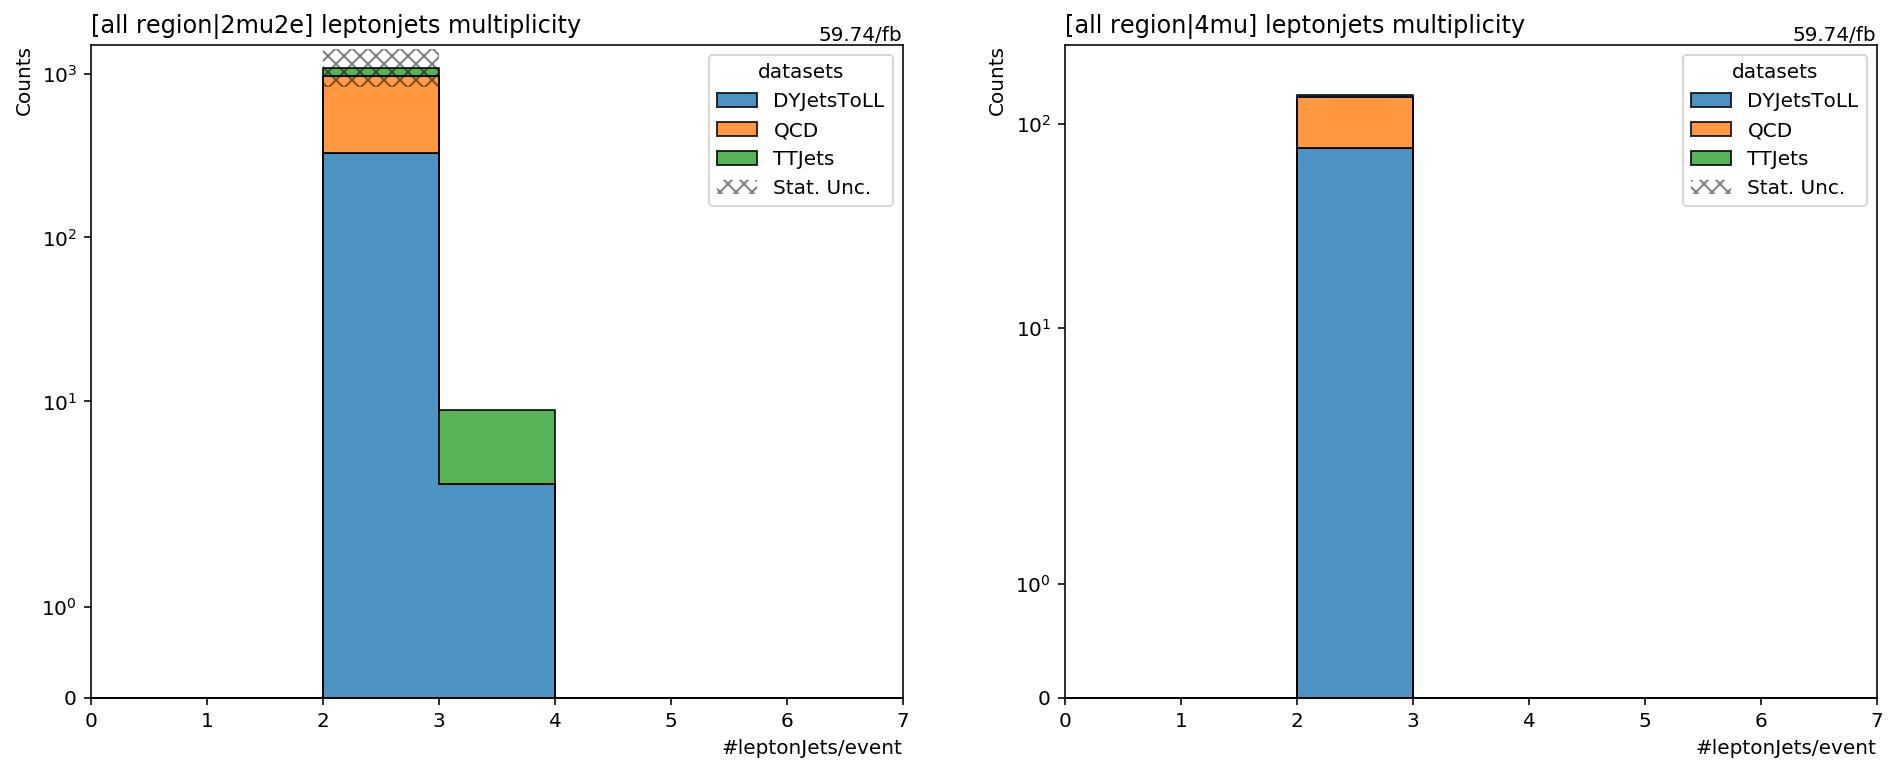

In [26]:
fig, axes =plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['multi_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region|2mu2e] leptonjets multiplicity', x=0.0, ha="left")
hist.plot1d(output['multi_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1], stack=True, overflow='over', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region|4mu] leptonjets multiplicity', x=0.0, ha="left")

for ax in axes.flat:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

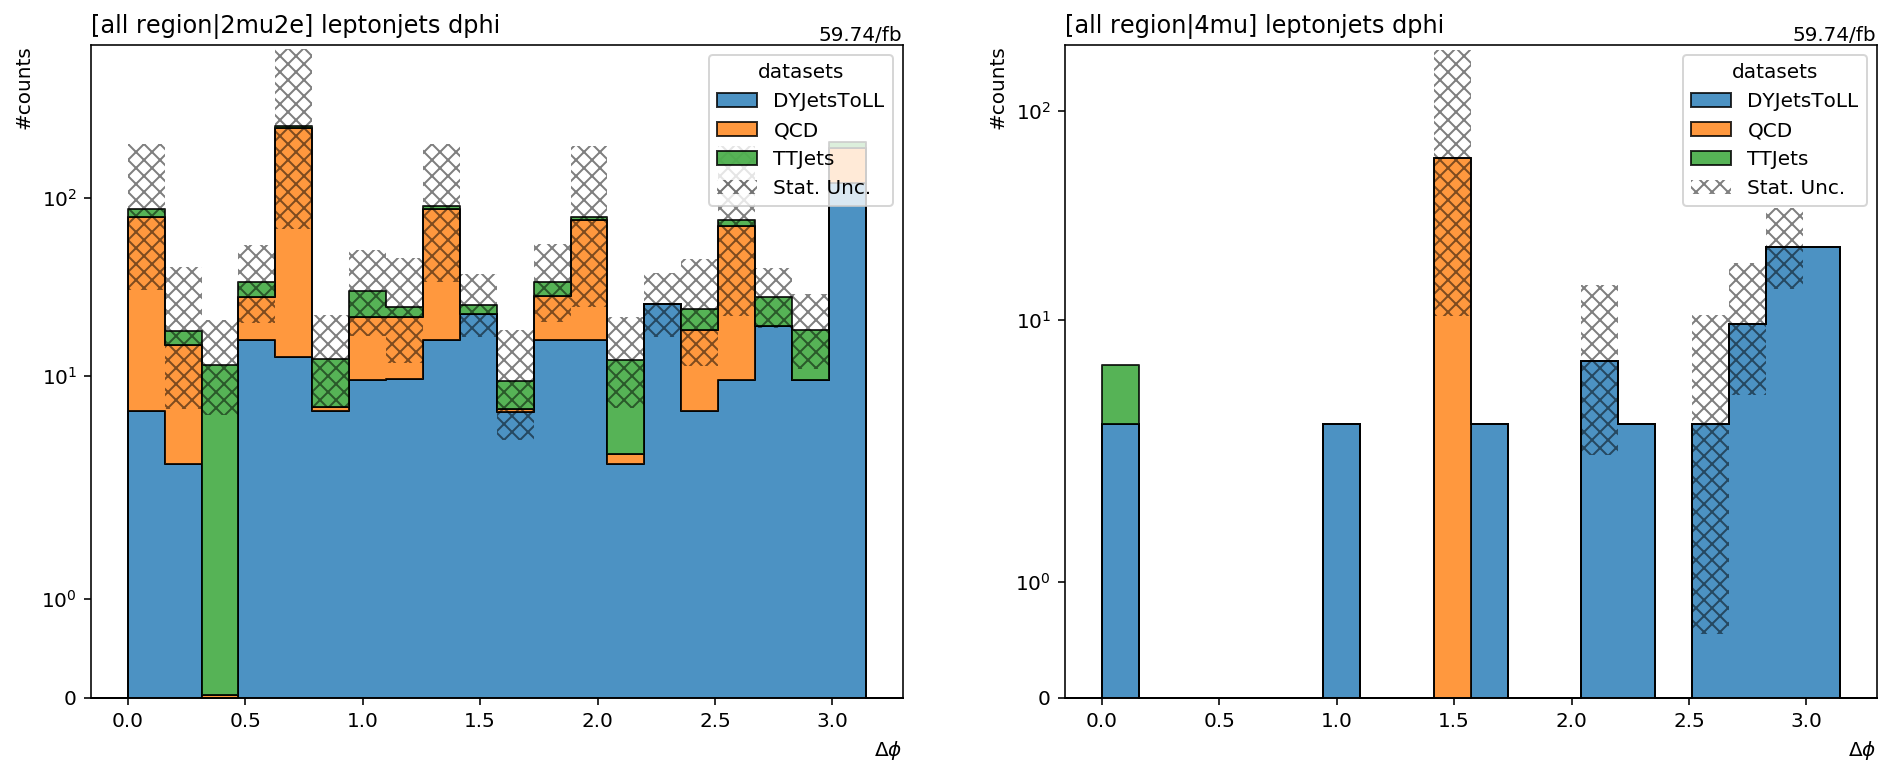

In [18]:
fig, axes =plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ljpair_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region|2mu2e] leptonjets dphi', x=0.0, ha="left")
hist.plot1d(output['ljpair_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1], stack=True, overflow='all', line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region|4mu] leptonjets dphi', x=0.0, ha="left")

for ax in axes.flat:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

In [22]:
cr_ = output['ljpair_cat'].integrate('channel', slice(1,2)).sum('cat').integrate('dphi', slice(0, np.pi/2)).values()[()]
sr_ = output['ljpair_cat'].integrate('channel', slice(1,2)).sum('cat').integrate('dphi', slice(np.pi/2, np.pi)).values()[()]
print('2mu2e | ', cr_, sr_, cr_/sr_)

cr_ = output['ljpair_cat'].integrate('channel', slice(2,3)).sum('cat').integrate('dphi', slice(0, np.pi/2)).values()[()]
sr_ = output['ljpair_cat'].integrate('channel', slice(2,3)).sum('cat').integrate('dphi', slice(np.pi/2, np.pi)).values()[()]
print('4mu | ', cr_, sr_, cr_/sr_)

2mu2e |  582.2093822694128 508.485249535161 1.144987750975368
4mu |  68.88356195568686 69.87207358247062 0.9858525505813562


## split by channels - leading & subleading

In [28]:
ptbinning = np.concatenate([np.arange(0, 400, 10),
                           np.arange(400, 600, 20),
                           np.arange(600, 800, 50)])
massbinning = np.concatenate([np.arange(0, 5, 0.5),
                             np.arange(5, 20, 1)])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        order_axis = hist.Bin('order', 'order', 2, 0, 2)
        
        self._accumulator = processor.dict_accumulator({
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis, order_axis),
            'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis, order_axis),
            'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis, order_axis),
            'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis, order_axis),
        })
#         self.pucorrs = get_pu_weights_function()
#         self.nlo_w = get_nlo_weight_function('w')
#         self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
#         nvtx = df['npv']
#         pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#         wgts.add('pileup', pu, puUp, puDown)
        
        triggermask = np.logical_and.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
#         metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         wgts.add('metfilters', metfiltermask)

#         wnlo = np.ones_like(df.size)
#         if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#             genparticles = JaggedCandidateArray.candidatesfromcounts(
#                 df['gen_p4'],
#                 px=df['gen_p4.fCoordinates.fX'],
#                 py=df['gen_p4.fCoordinates.fY'],
#                 pz=df['gen_p4.fCoordinates.fZ'],
#                 energy=df['gen_p4.fCoordinates.fT'],
#                 pid=df['gen_pid'],
#             )
#             gentops = genparticles[np.abs(genparticles.pid)==6]
#             genws = genparticles[np.abs(genparticles.pid)==24]
#             genzs = genparticles[np.abs(genparticles.pid)==23]

#             if 'TTJets' in dataset:
#                 wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#             elif 'WJets' in dataset:
#                 wnlo = self.nlo_w(genws[0].p4.pt.sum())
#             elif 'DYJets' in dataset:
#                 wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#         wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
#         leptonjetpair = dileptonjets.distincts()
#         sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
#         if sumpt.size==0: return output
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu

#         leadingLjPair = leptonjetpair[sumpt.argmax()]
#         controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
#         leptonjets_ = dileptonjets[controlregion.flatten()]
#         wgt = wgt[controlregion.flatten()]
        leptonjets_ = dileptonjets

        
#         ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
#         ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljpt'].fill(dataset=dataset, pt=lj0.pt.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljeta'].fill(dataset=dataset, eta=lj0.eta.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljphi'].fill(dataset=dataset, phi=lj0.phi.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        output['ljmass'].fill(dataset=dataset, mass=lj0.mass.flatten(), label=lj0.label.flatten(), weight=wgt, channel=channel_, order=np.zeros(lj0.size))
        
        output['ljpt'].fill(dataset=dataset, pt=lj1.pt.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljeta'].fill(dataset=dataset, eta=lj1.eta.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljphi'].fill(dataset=dataset, phi=lj1.phi.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))
        output['ljmass'].fill(dataset=dataset, mass=lj1.mass.flatten(), label=lj1.label.flatten(), weight=wgt, channel=channel_, order=np.ones(lj1.size))

        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [29]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2435/2435 [01:22<00:00, 29.45items/s]


In [30]:
def makeplot2(key, text, overflow='over', logy=True):
    fig, axes =plt.subplots(2,2,figsize=(16,12))
    hist.plot1d(output[key].sum('label').integrate('order', slice(0,1)).integrate('channel', slice(1,2))
                , overlay='cat', ax=axes[0][0], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[0][0].set_title(f'[all region|2mu2e] leading leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].sum('label').integrate('order', slice(1,2)).integrate('channel', slice(1,2))
                , overlay='cat', ax=axes[0][1], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[0][1].set_title(f'[all region|2mu2e] subleading leptonJets {text}', x=0.0, ha="left")


    hist.plot1d(output[key].sum('label').integrate('order', slice(0,1)).integrate('channel', slice(2,3))
                , overlay='cat', ax=axes[1][0], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[1][0].set_title(f'[all region|4mu] leading leptonJets {text}', x=0.0, ha="left")
    hist.plot1d(output[key].sum('label').integrate('order', slice(1,2)).integrate('channel', slice(2,3))
                , overlay='cat', ax=axes[1][1], stack=True, overflow=overflow, line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    axes[1][1].set_title(f'[all region|4mu] subleading leptonJets {text}', x=0.0, ha="left")


    for ax in axes.flat:
        ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

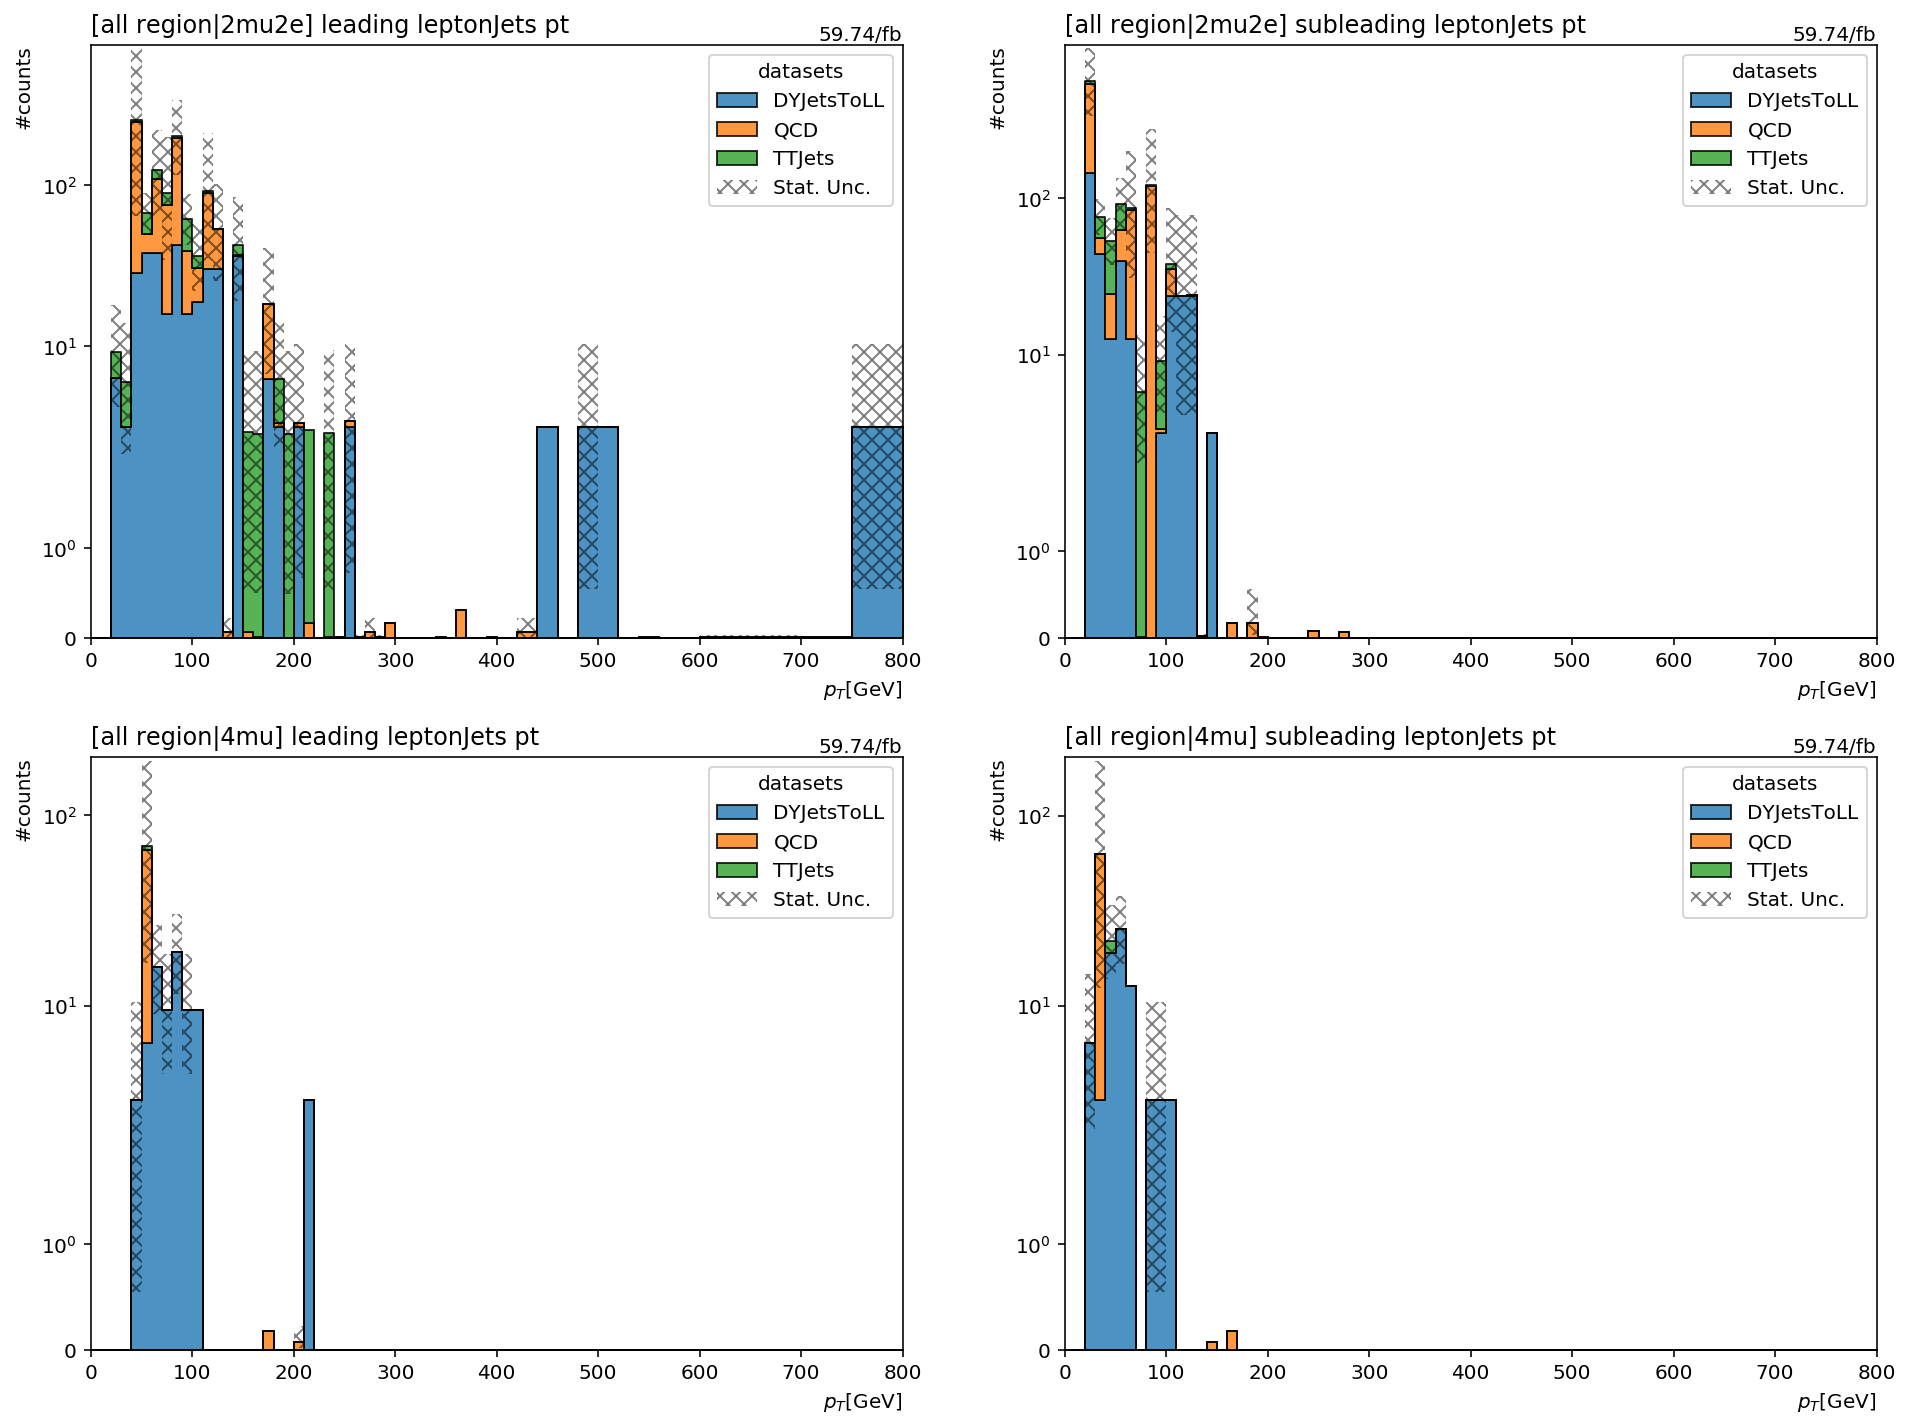

In [31]:
makeplot2('ljpt_cat', 'pt', overflow='over')

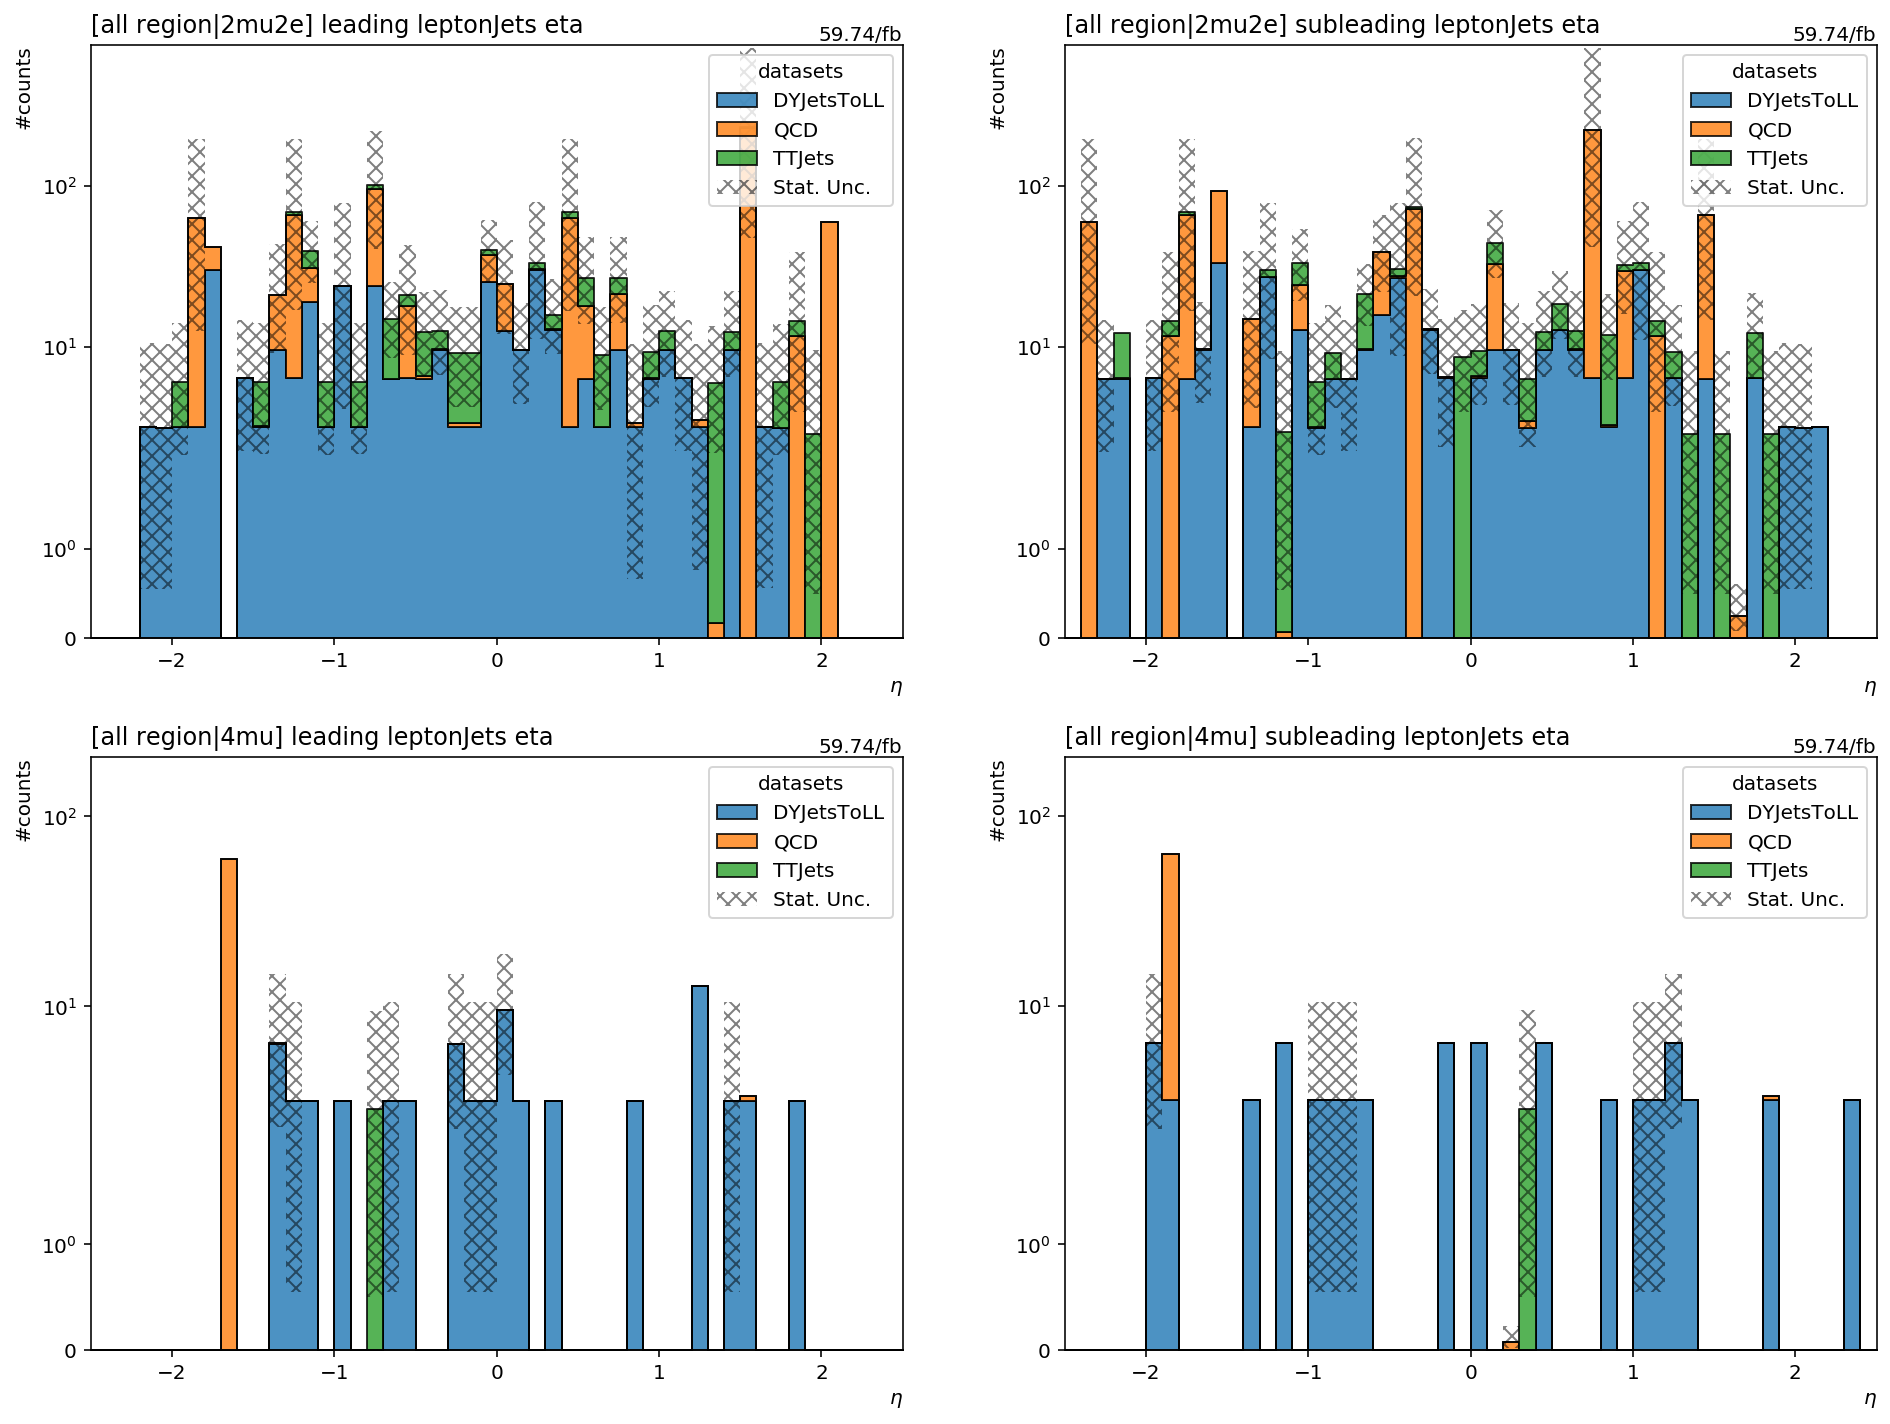

In [32]:
makeplot2('ljeta_cat', 'eta', overflow='all')

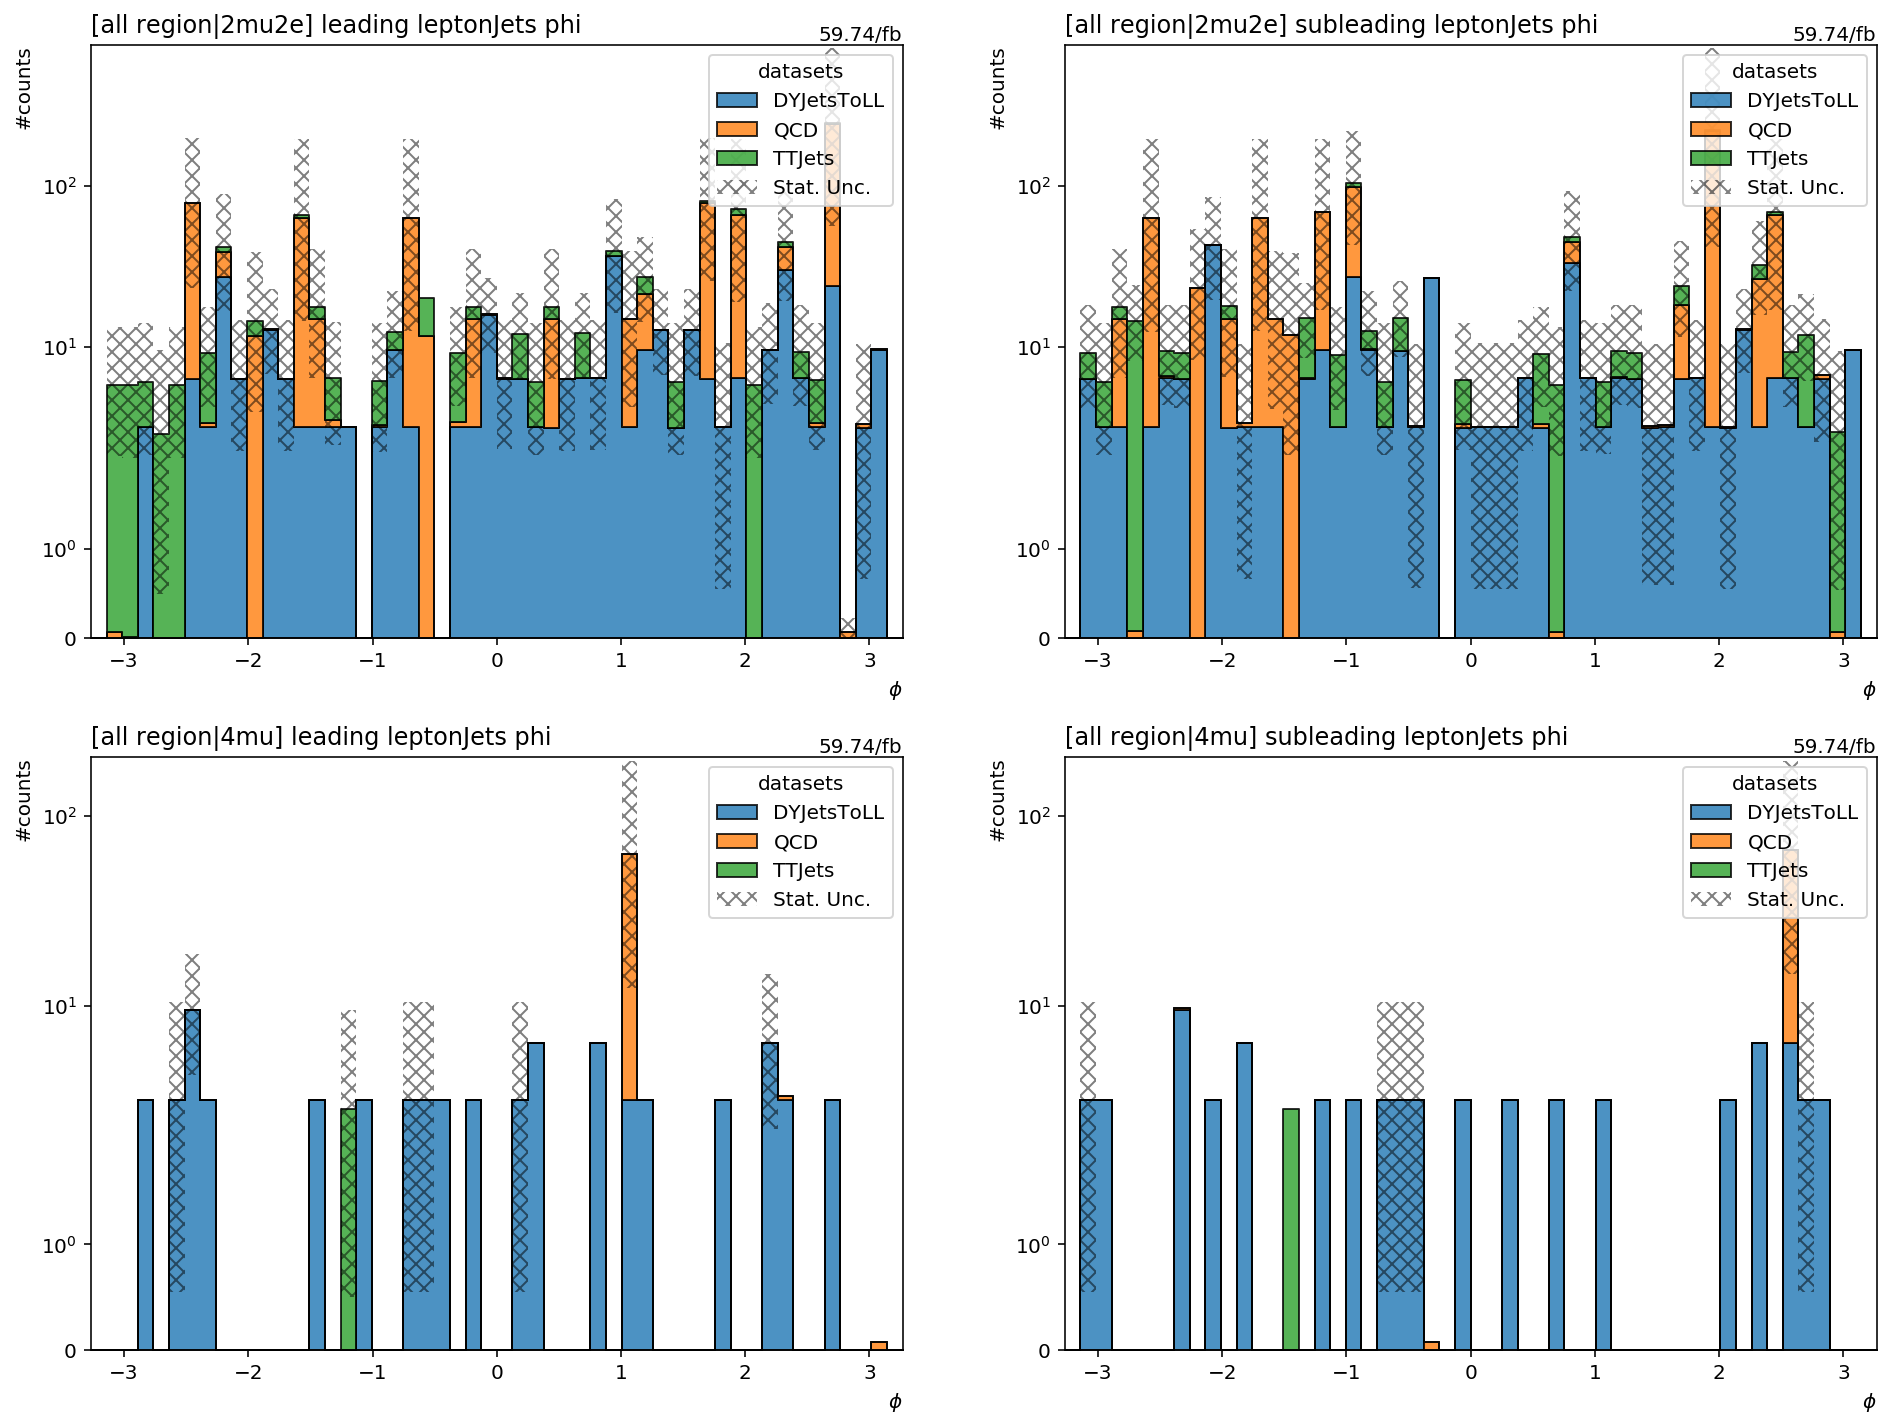

In [33]:
makeplot2('ljphi_cat', 'phi', overflow='all')

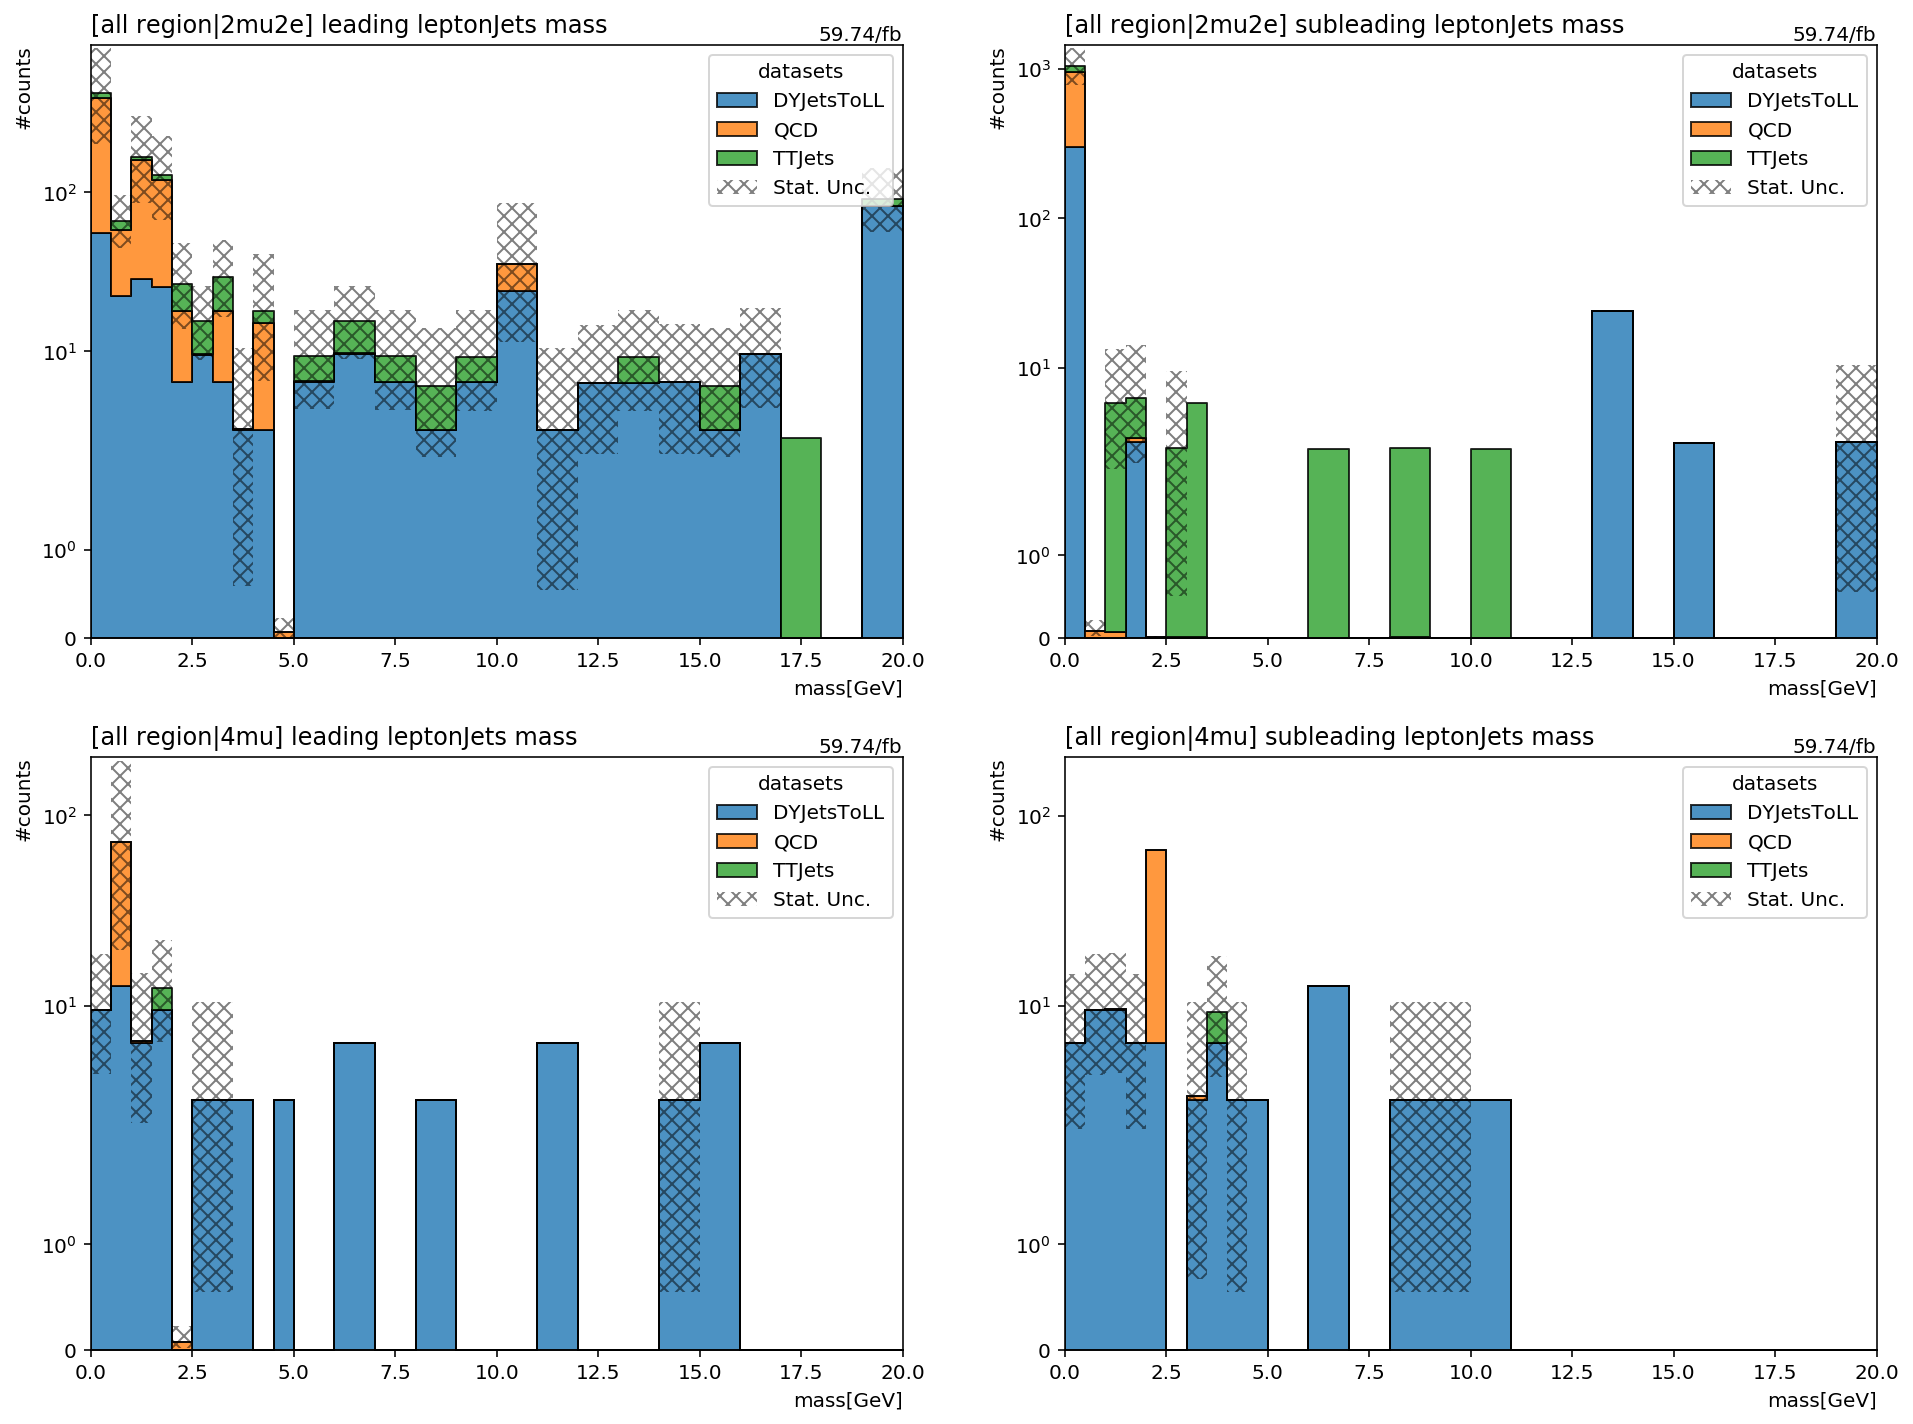

In [34]:
makeplot2('ljmass_cat', 'mass', overflow='over')

## leptonjet isolation vars

In [6]:
ptbinning = np.concatenate([np.arange(0, 400, 10),
                           np.arange(400, 600, 20),
                           np.arange(600, 800, 50)])
massbinning = np.concatenate([np.arange(0, 5, 0.5),
                             np.arange(5, 20, 1)])

class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        multiplicity_axis = hist.Bin("multiplicity", "#leptonJets/event", 6, 0, 6)
        pt_axis = hist.Bin("pt", "$p_T$[GeV]", ptbinning)
        mass_axis = hist.Bin('mass', 'mass[GeV]', massbinning)
        eta_axis = hist.Bin('eta', '$\eta$', 48, -2.4, 2.4)
        phi_axis = hist.Bin('phi', '$\phi$', 50, -np.pi, np.pi)
        tkiso05_axis = hist.Bin('tkiso05', 'track isolation 0.5', 50, 0, 1)
        pfiso05_axis = hist.Bin('pfiso05', 'pfcands isolation 0.5', 50, 0, 1)
        pfiso_axis = hist.Bin('pfiso', 'pfiso', 30, 0, 0.3)
        mindr_axis = hist.Bin('mindr', 'min$\Delta$R', 50, 0.4, np.pi)
        qsum_axis = hist.Bin('qsum', '$\Sigma q$', 5, -2, 3)
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 50, 0, np.pi)
        invm_axis = hist.Bin('invm', 'invM [GeV]', 50, 0, 300)
        label_axis    = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        
        self._accumulator = processor.dict_accumulator({
            'multi': hist.Hist("Counts", dataset_axis, multiplicity_axis, channel_axis),
            'ljpt': hist.Hist("#counts", dataset_axis, pt_axis, label_axis, channel_axis),
#             'ljeta': hist.Hist("#counts", dataset_axis, eta_axis, label_axis, channel_axis),
#             'ljphi': hist.Hist("#counts", dataset_axis, phi_axis, label_axis, channel_axis),
#             'ljmass': hist.Hist("#counts", dataset_axis, mass_axis, label_axis, channel_axis),
            'ljtkiso05': hist.Hist("#counts", dataset_axis, tkiso05_axis, label_axis, channel_axis),
            'ljpfiso05': hist.Hist("#counts", dataset_axis, pfiso05_axis, label_axis, channel_axis),
            'ljpfiso': hist.Hist("#counts", dataset_axis, pfiso_axis, label_axis, channel_axis),
            'ljmindr': hist.Hist("#counts", dataset_axis, mindr_axis, label_axis, channel_axis),
            'ljqsum': hist.Hist("#counts", dataset_axis, qsum_axis, label_axis, channel_axis),
            "ljpairdphi": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            "ljpairinvm": hist.Hist("#counts", dataset_axis, invm_axis, channel_axis),
            "ljpairmassdiff": hist.Hist("#counts", dataset_axis, mass_axis, channel_axis),
        })
#         self.pucorrs = get_pu_weights_function()
#         self.nlo_w = get_nlo_weight_function('w')
#         self.nlo_z = get_nlo_weight_function('z')
        
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        wgts.add('genw', df['weight'])
        
#         nvtx = df['npv']
#         pu, puUp, puDown = (f(nvtx) for f in self.pucorrs)
#         wgts.add('pileup', pu, puUp, puDown)
        
#         metfiltermask = np.logical_and.reduce([df[mf] for mf in MetFilters])
#         wgts.add('metfilters', metfiltermask)

#         wnlo = np.ones_like(df.size)
#         if 'TTJets' in dataset or 'WJets' in dataset or 'DYJets' in dataset:
#             genparticles = JaggedCandidateArray.candidatesfromcounts(
#                 df['gen_p4'],
#                 px=df['gen_p4.fCoordinates.fX'],
#                 py=df['gen_p4.fCoordinates.fY'],
#                 pz=df['gen_p4.fCoordinates.fZ'],
#                 energy=df['gen_p4.fCoordinates.fT'],
#                 pid=df['gen_pid'],
#             )
#             gentops = genparticles[np.abs(genparticles.pid)==6]
#             genws = genparticles[np.abs(genparticles.pid)==24]
#             genzs = genparticles[np.abs(genparticles.pid)==23]

#             if 'TTJets' in dataset:
#                 wnlo = np.sqrt(get_ttbar_weight(gentops[0].p4.pt.sum()) * get_ttbar_weight(gentops[1].p4.pt.sum()))
#             elif 'WJets' in dataset:
#                 wnlo = self.nlo_w(genws[0].p4.pt.sum())
#             elif 'DYJets' in dataset:
#                 wnlo = self.nlo_z(genzs[0].p4.pt.sum())
#         wgts.add('nlo', wnlo)
            
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            tkiso05=df['pfjet_tkIsolation05'],
            pfiso05=df['pfjet_pfIsolation05'],
            pfiso=df['pfjet_pfiso'],
            mindr=df['pfjet_mindr'],
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
#         leptonjetpair = dileptonjets.distincts()
#         sumpt = leptonjetpair.i0.pt+leptonjetpair.i1.pt
#         if sumpt.size==0: return output
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu

#         leadingLjPair = leptonjetpair[sumpt.argmax()]
#         controlregion = np.abs(leadingLjPair.i0.p4.delta_phi(leadingLjPair.i1.p4))<2.5
#         leptonjets_ = dileptonjets[controlregion.flatten()]
#         wgt = wgt[controlregion.flatten()]
        leptonjets_ = dileptonjets

        
        output['multi'].fill(dataset=dataset, multiplicity=leptonjets_.counts, weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljpt'].fill(dataset=dataset, pt=leptonjets_.pt.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljeta'].fill(dataset=dataset, eta=leptonjets_.eta.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljphi'].fill(dataset=dataset, phi=leptonjets_.phi.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
#         output['ljmass'].fill(dataset=dataset, mass=leptonjets_.mass.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljtkiso05'].fill(dataset=dataset, tkiso05=(leptonjets_.tkiso05*leptonjets_.pt/100).flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljpfiso05'].fill(dataset=dataset, pfiso05=(leptonjets_.pfiso05*leptonjets_.pt/100).flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljpfiso'].fill(dataset=dataset, pfiso=leptonjets_.pfiso.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljmindr'].fill(dataset=dataset, mindr=leptonjets_.mindr.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        output['ljqsum'].fill(dataset=dataset, qsum=leptonjets_.qsum.flatten(), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)

        output['ljpairdphi'].fill(dataset=dataset, dphi=(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        output['ljpairinvm'].fill(dataset=dataset, invm=(lj0.p4+lj1.p4).mass.flatten(), weight=wgt, channel=channel_)
        output['ljpairmassdiff'].fill(dataset=dataset, mass=np.abs(lj0.mass-lj1.mass).flatten(), weight=wgt, channel=channel_)
        
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(scales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [7]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 2440/2440 [01:33<00:00, 26.18items/s]


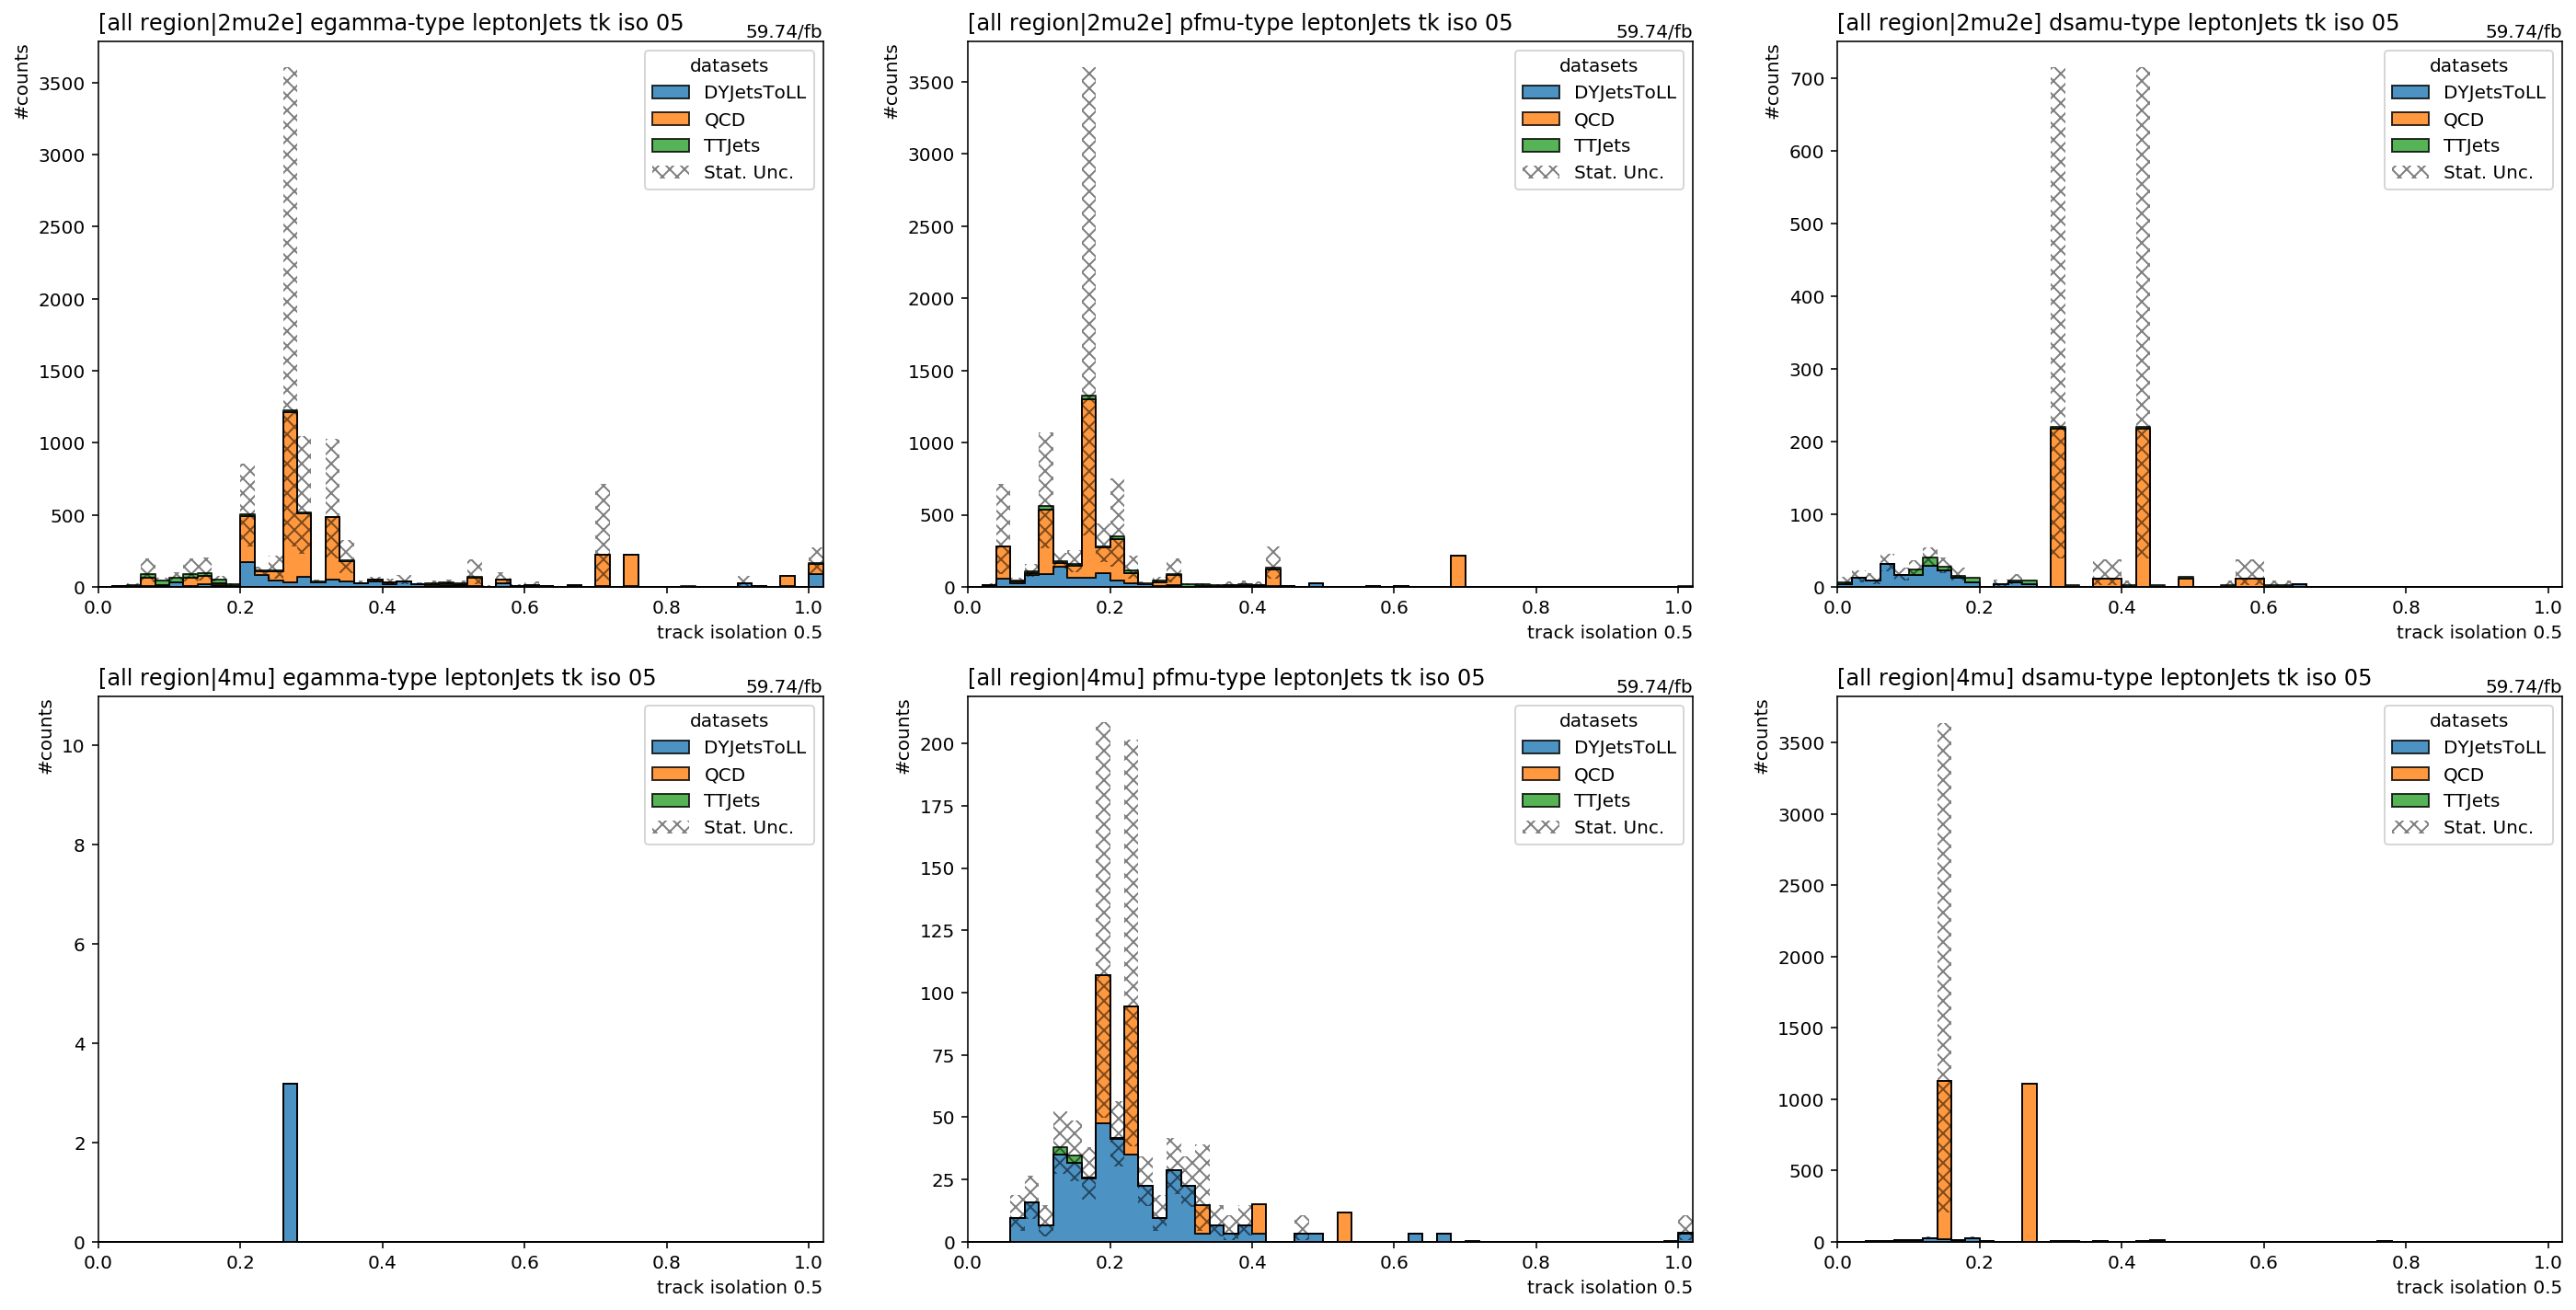

In [30]:
makeplot('ljtkiso05_cat', 'tk iso 05', logy=False)

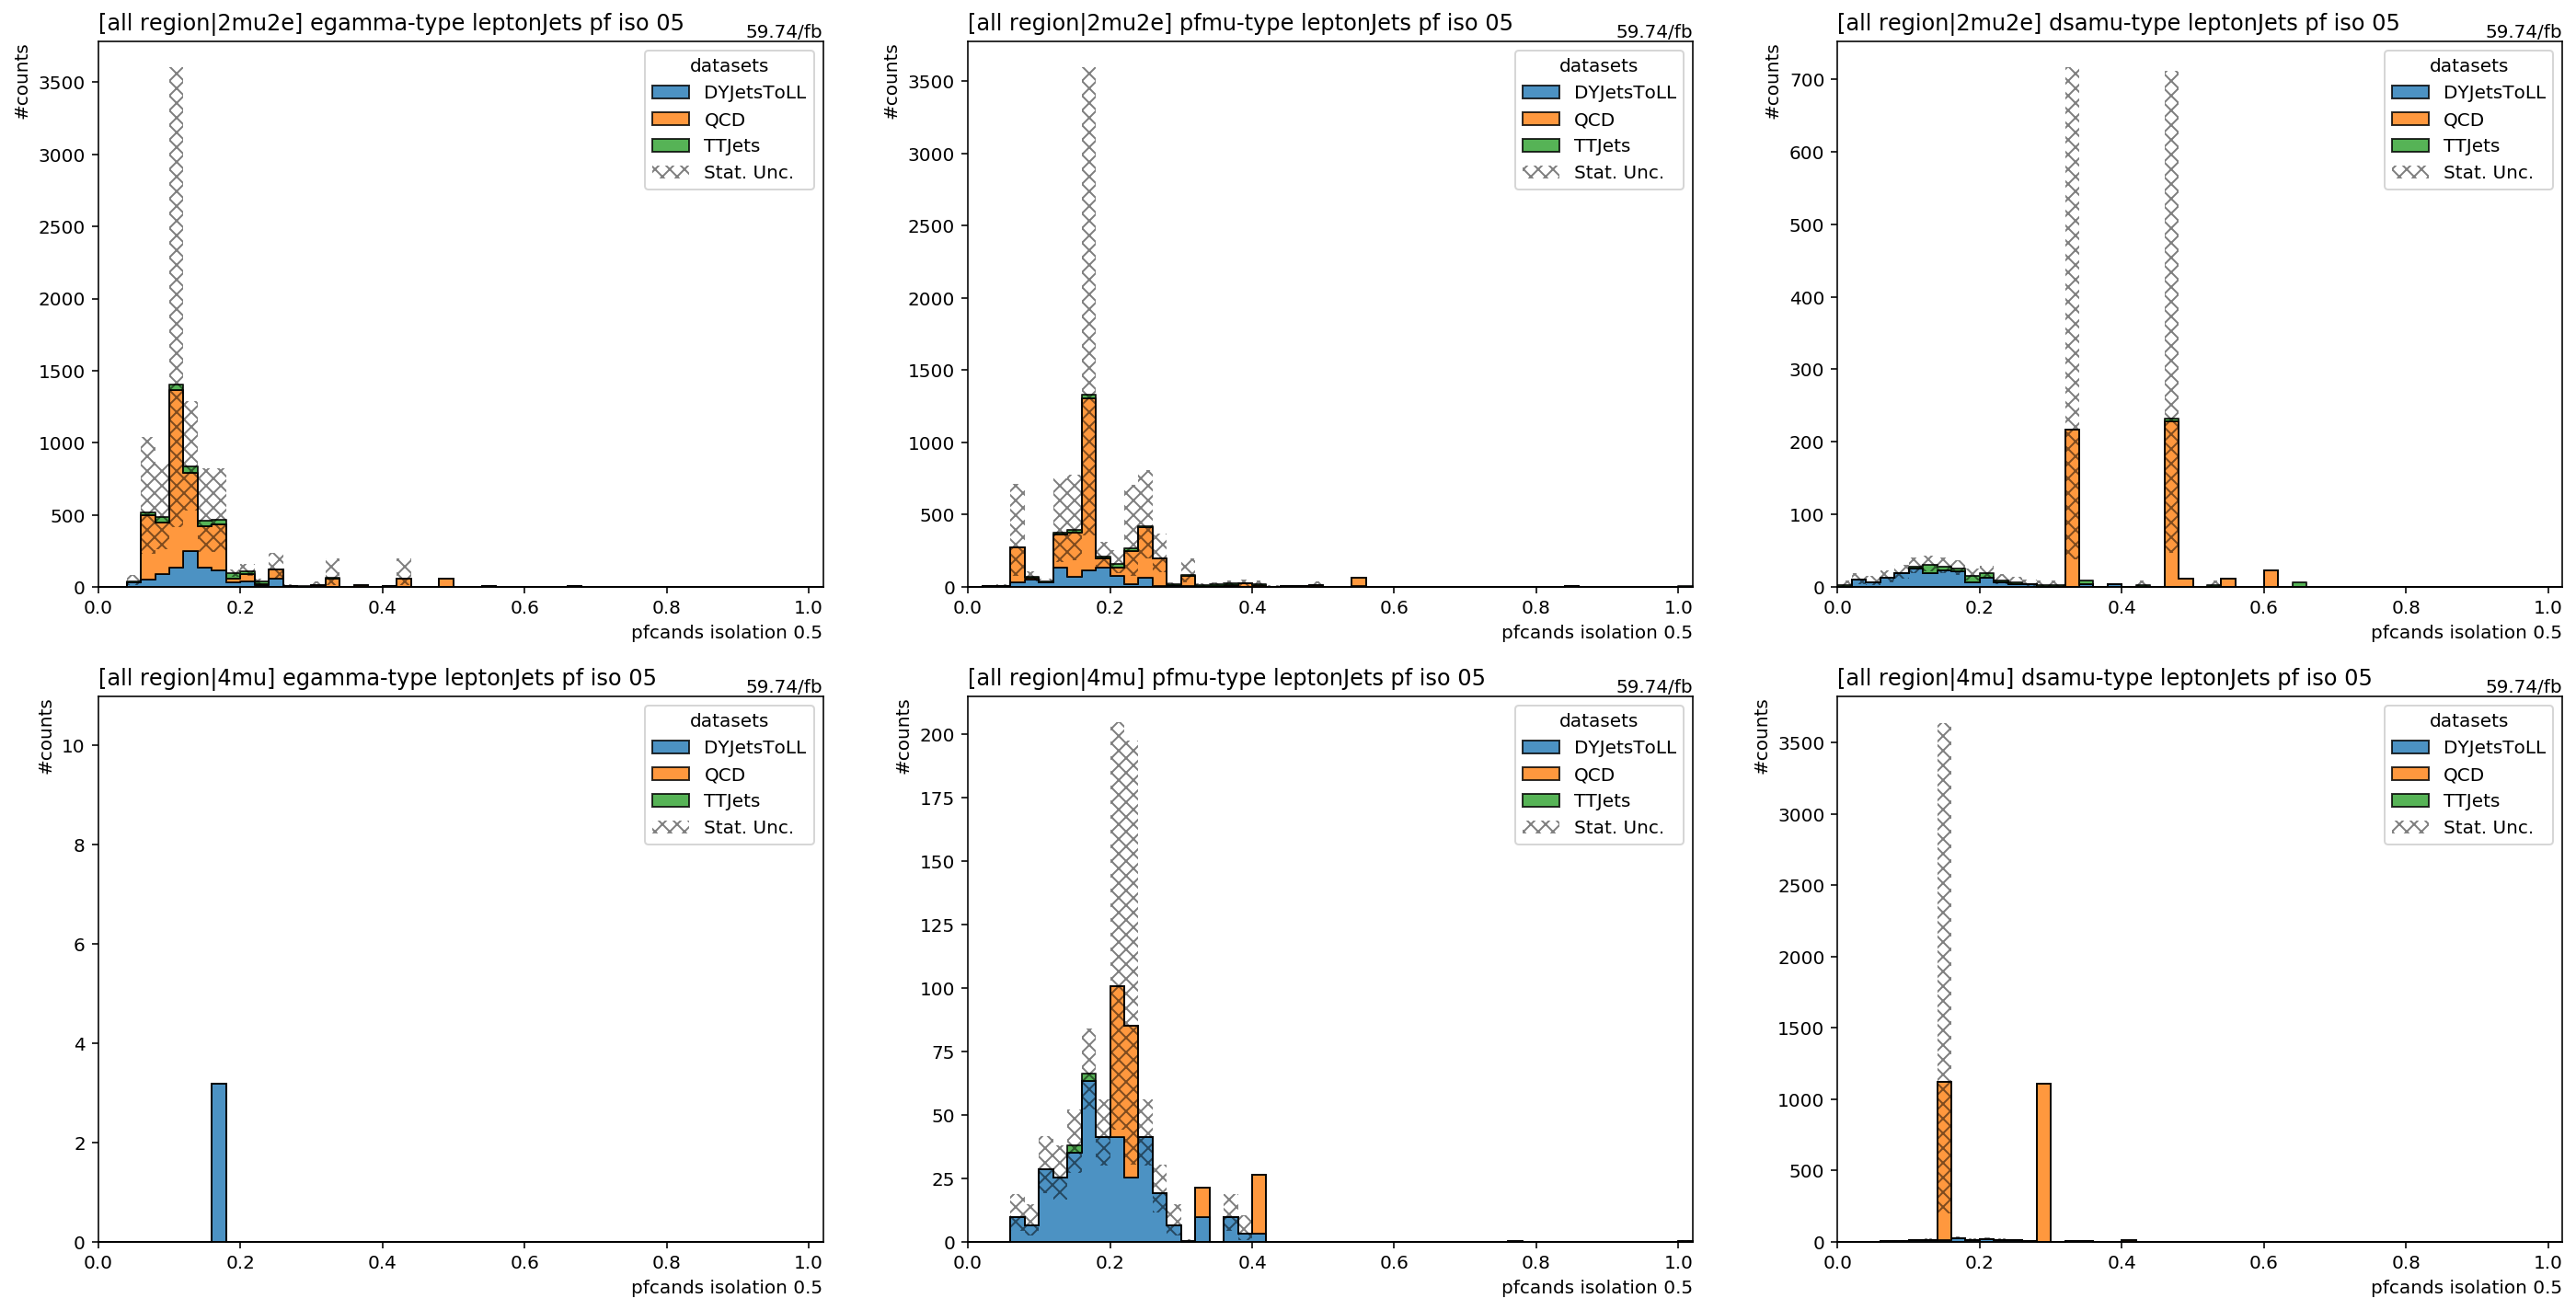

In [31]:
makeplot('ljpfiso05_cat', 'pf iso 05', logy=False)

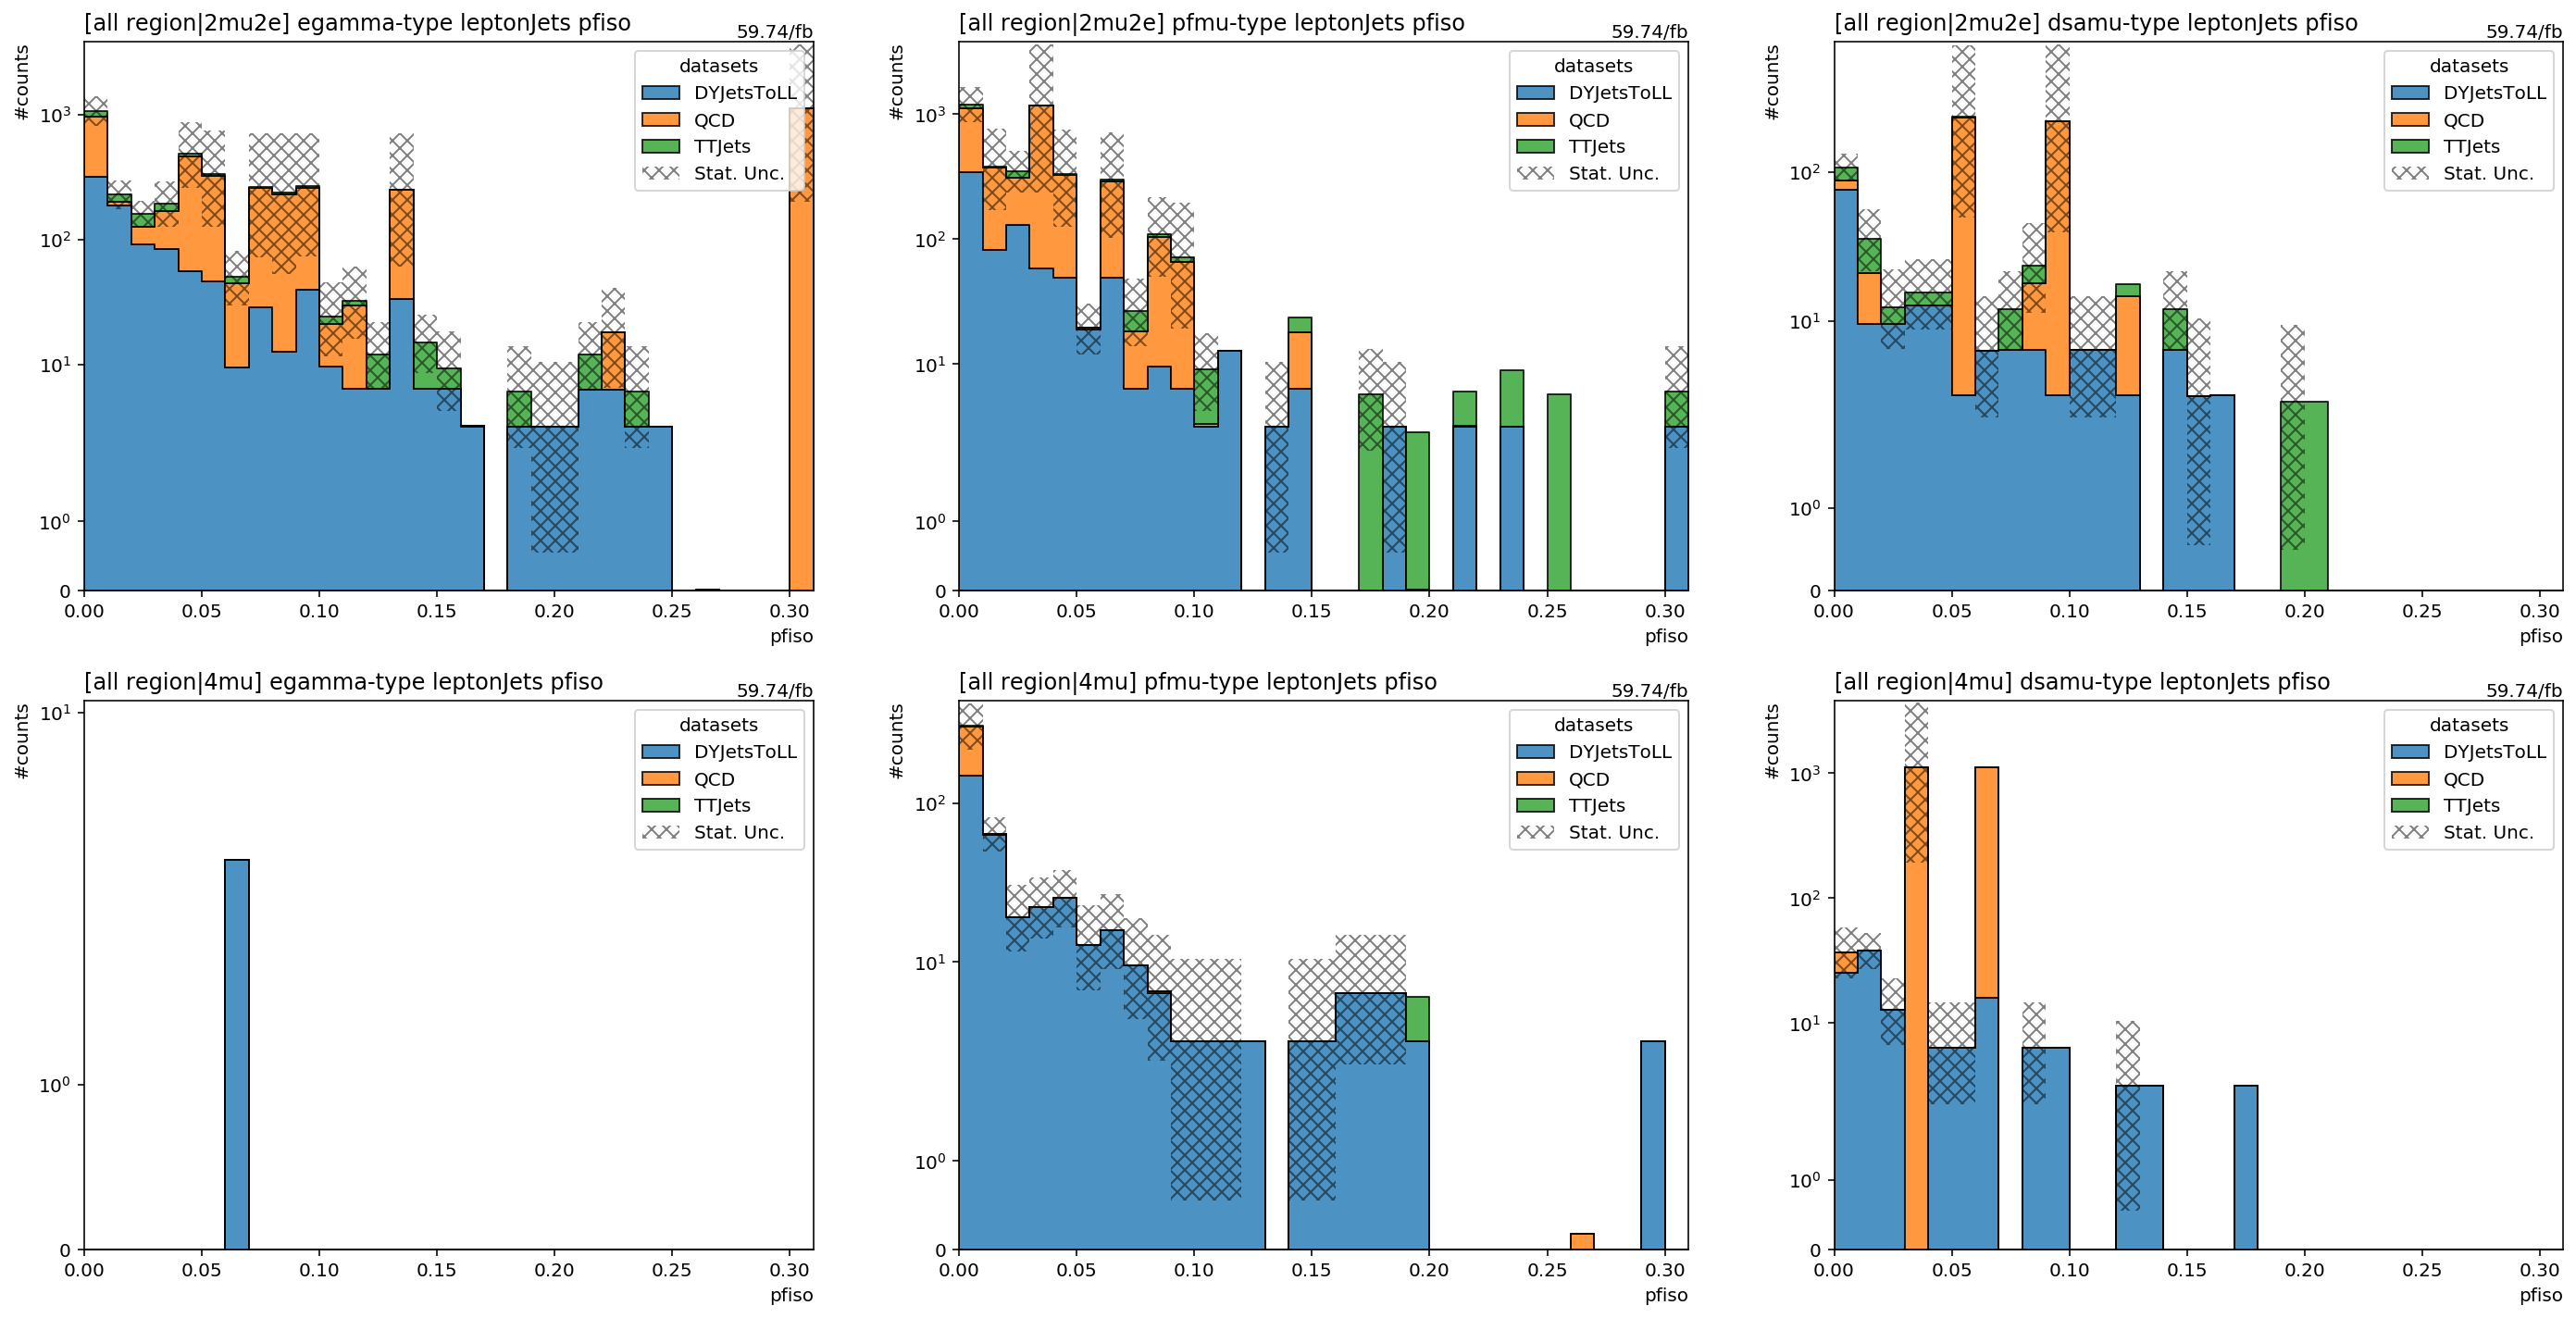

In [32]:
makeplot('ljpfiso_cat', 'pfiso')

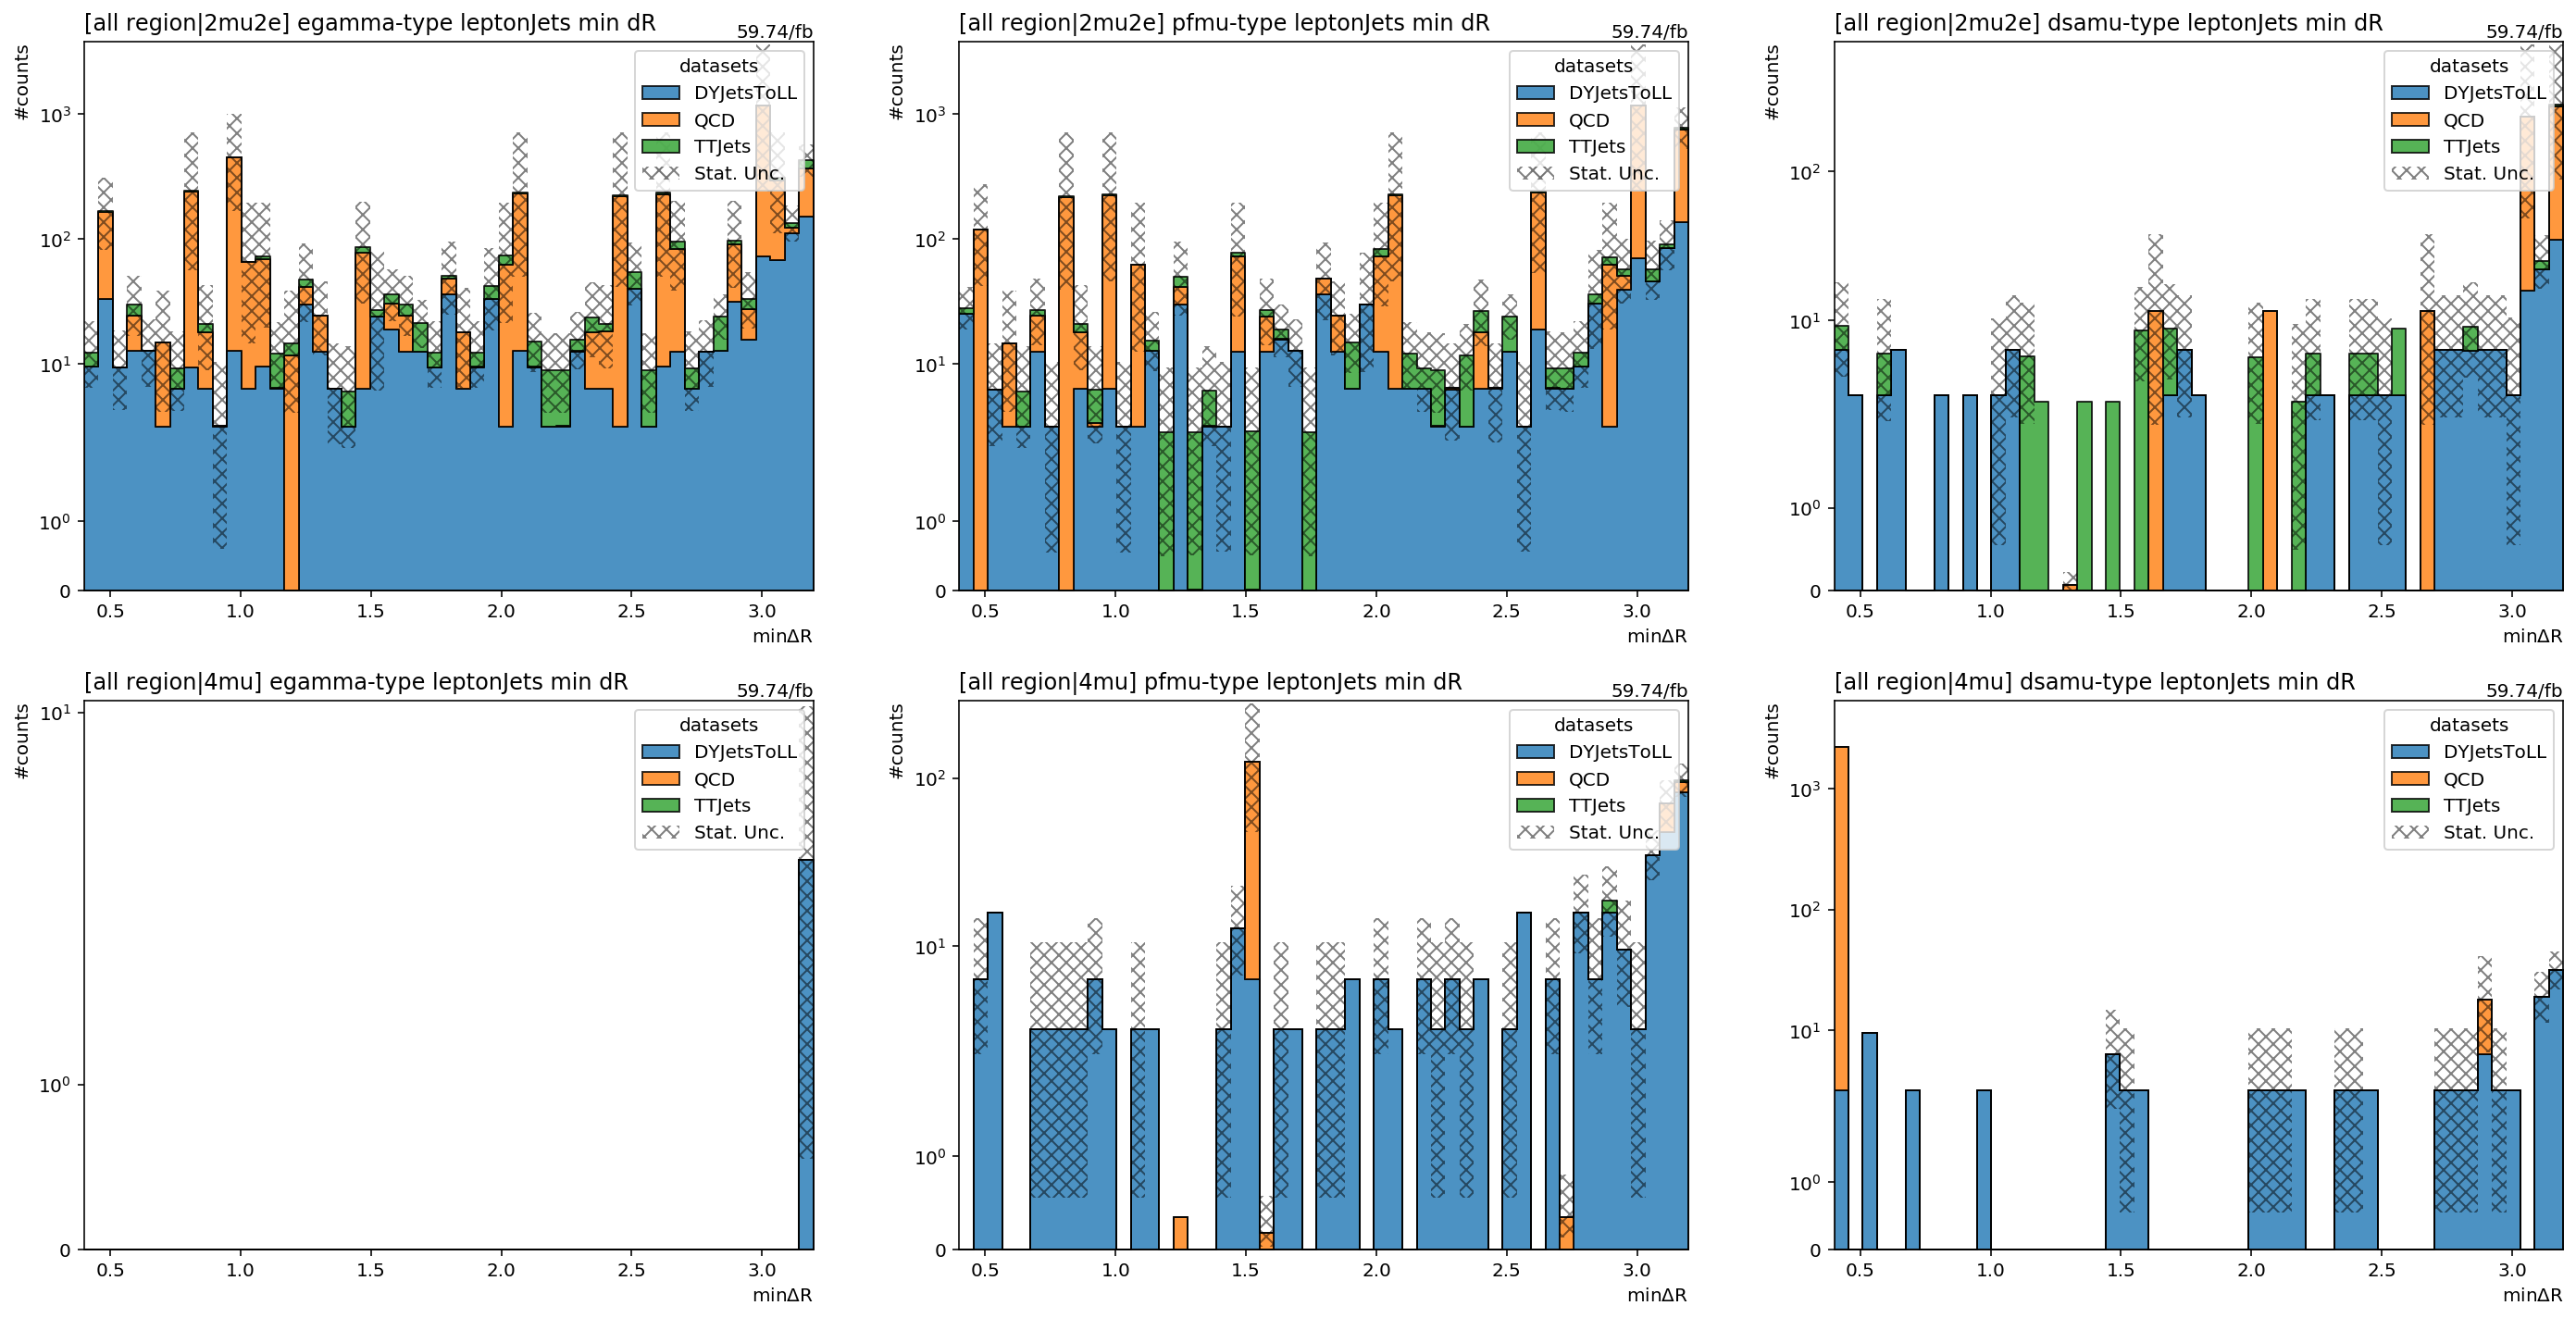

In [19]:
makeplot('ljmindr_cat', 'min dR')

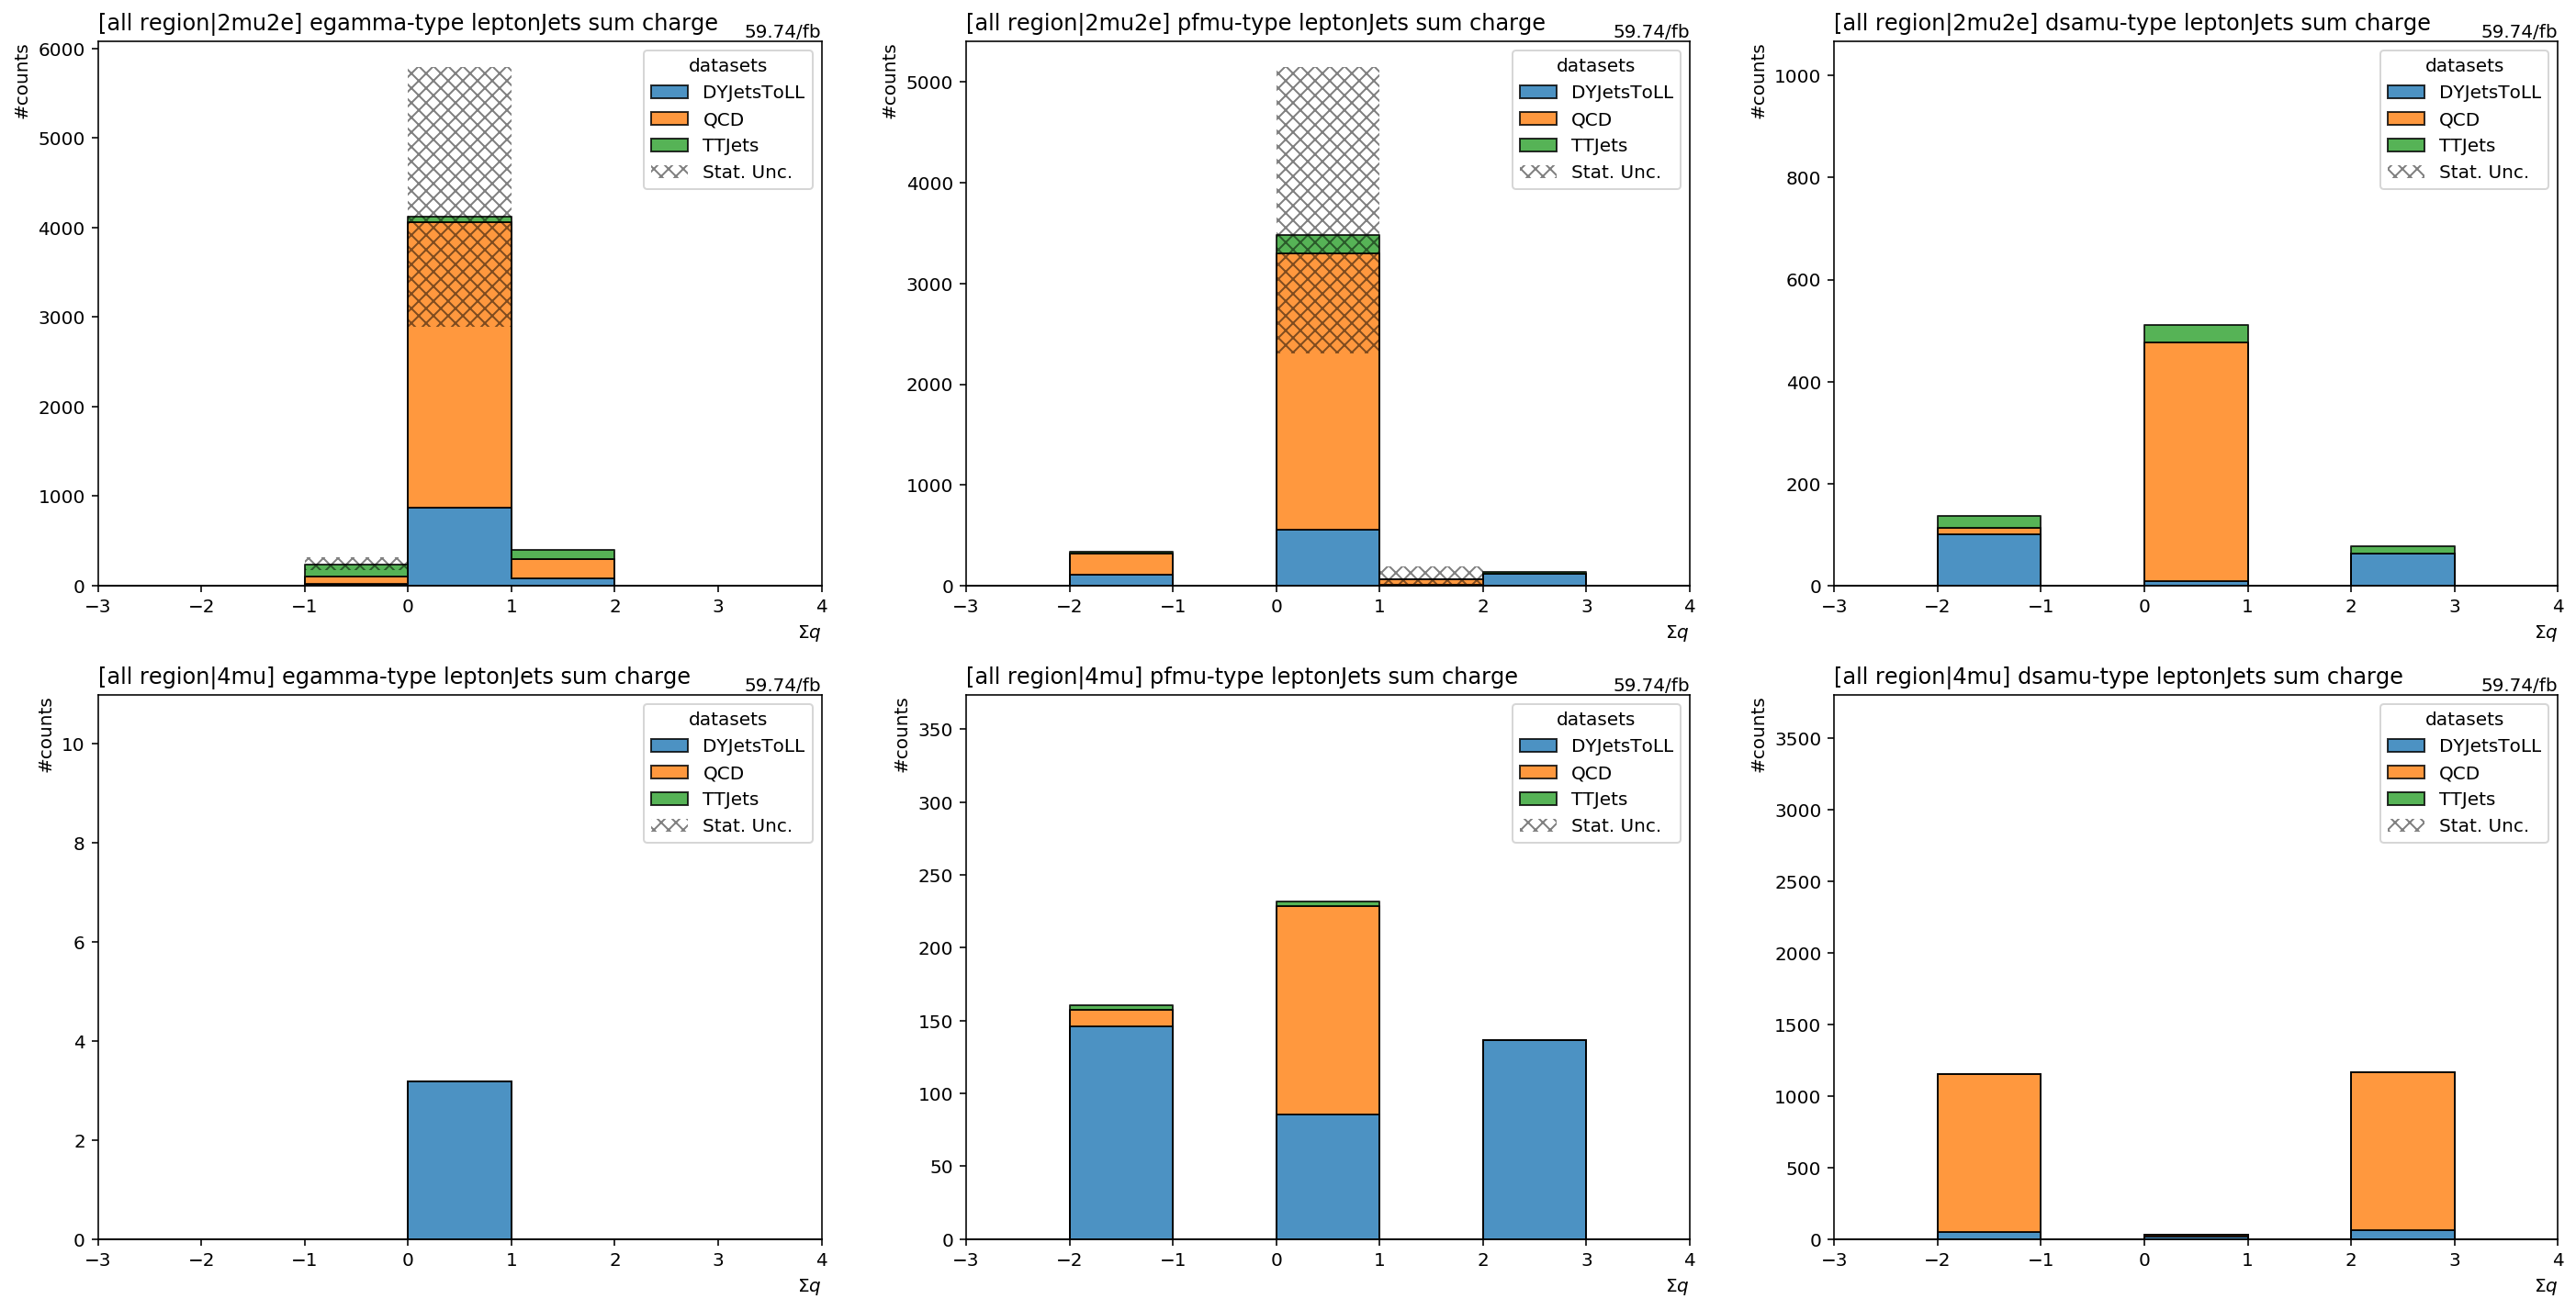

In [11]:
makeplot('ljqsum_cat', 'sum charge', logy=False, overflow='all')

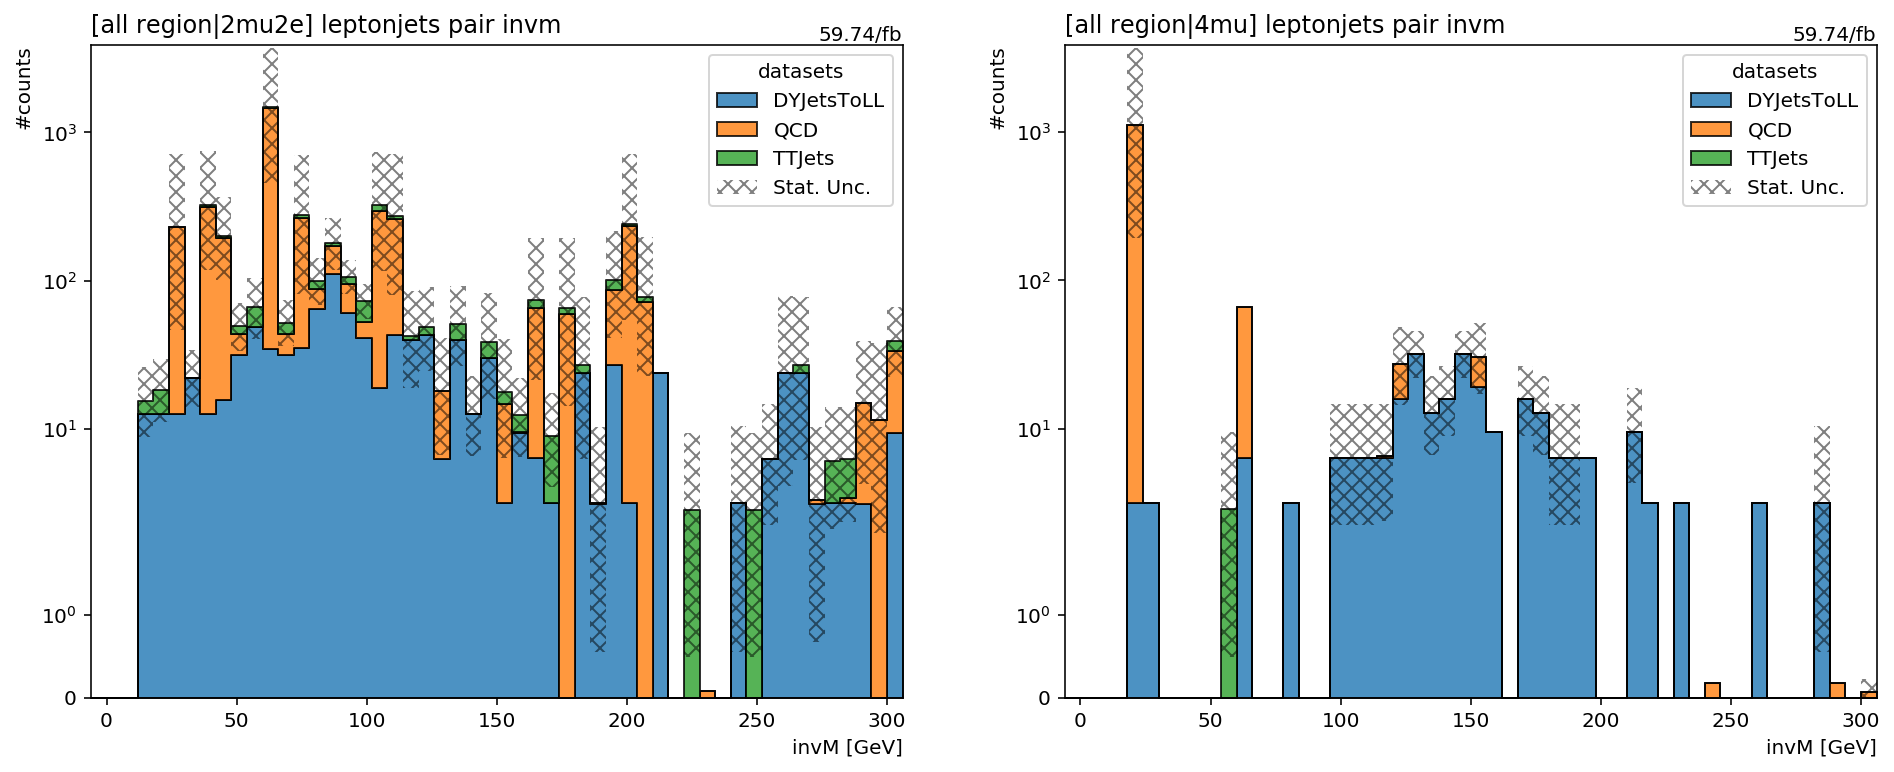

In [21]:
fig, axes =plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ljpairinvm_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0], stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region|2mu2e] leptonjets pair invm', x=0.0, ha="left")
hist.plot1d(output['ljpairinvm_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1], stack=True, overflow='all',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region|4mu] leptonjets pair invm', x=0.0, ha="left")

for ax in axes.flat:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

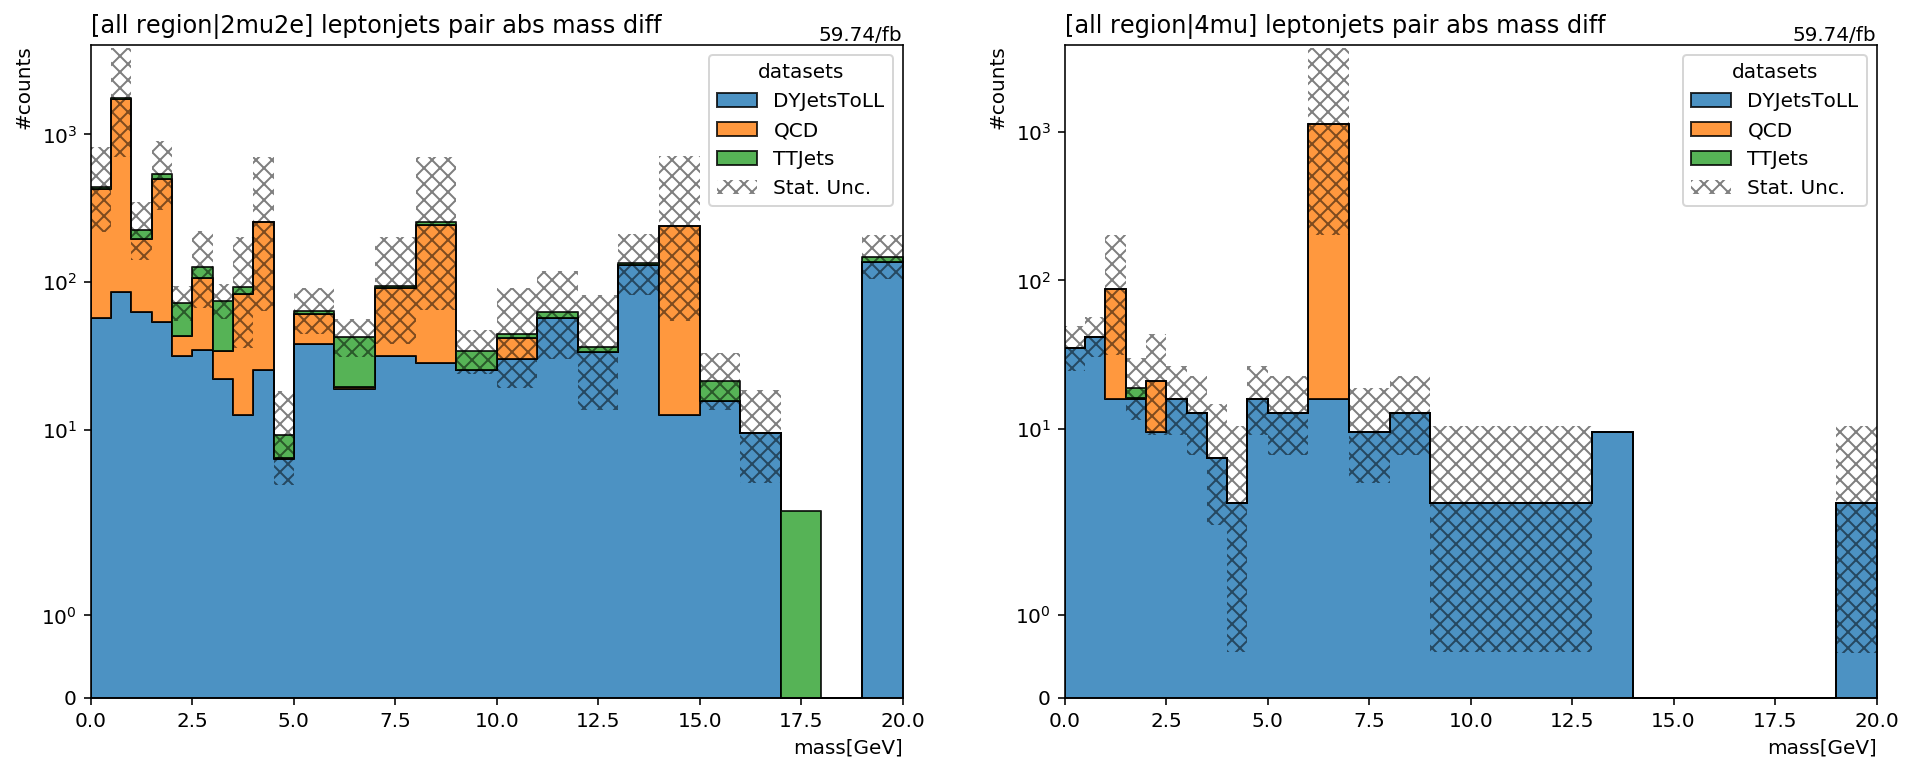

In [20]:
fig, axes =plt.subplots(1,2,figsize=(16,6))
hist.plot1d(output['ljpairmassdiff_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0], stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[0].set_title('[all region|2mu2e] leptonjets pair abs mass diff', x=0.0, ha="left")
hist.plot1d(output['ljpairmassdiff_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1], stack=True, overflow='over',
           line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
axes[1].set_title('[all region|4mu] leptonjets pair abs mass diff', x=0.0, ha="left")

for ax in axes.flat:
    ax.text(1,1,'59.74/fb', ha='right', va='bottom', transform=ax.transAxes)
    ax.set_yscale('symlog')
    ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
    ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");